# Introduction

# Data Overview

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
csv = ("employee_reviews.csv")
df = pd.read_csv(csv, encoding='latin1') # solves enocding issue when importing csv
df.head(5)

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


In [2]:
df['company'].unique()

array(['google', 'amazon', 'facebook', 'netflix', 'apple', 'microsoft'],
      dtype=object)

# Topics Analysis for Google

In [3]:
# Filters to Google only
dfg = df[df['company'] == 'google']

In [4]:
# Filters the data to the column needed for topic modeling
dfg = dfg[['summary']]
dfg.shape

(7819, 1)

7819 dataset with 1 type

In [5]:
dfg = dfg.head(500)

## Data Cleansing

In [6]:
data = dfg['summary'].values.tolist() # convert to list

import re
data = [re.sub(r'[^a-zA-Z ]+', '', str(sent)) for sent in data] # removes everything except letters and space, str(sent) converts to string

In [7]:
from pprint import pprint
pprint(data[:1])

['Best Company to work for']


## Pre-Processing

### Tokenization and Additional Cleansing

In [8]:
import gensim
from gensim.utils import simple_preprocess 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
        # deacc=True removes punctuations
        # simple_preprocess to tokenize, and clean up messy text (converts to lowercase and removes punctuations)
        
data_words = list(sent_to_words(data))

print(data_words[:1])   

[['best', 'company', 'to', 'work', 'for']]


### Remove Stopwords

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) # add additional stop words

# Define functions for stopwords, bigram, trigram and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # clean out words using simple_preprocess (gensim) if the words are not already in stop_words (stop_words from NLTK)
    
# Remove Stop Words from simple_preprocess
data_words_nostops = remove_stopwords(data_words)

### Create and Apply Trigrams

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# min_count is minimum 5 letters
# threshold is 100 threshold in each word before accepting another word

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_trigram(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Trigrams from Gensim.models.phrases
data_words_trigrams = make_trigram(data_words_nostops)

### Lemmatize

In [11]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): # http://spacy.io/api/annotation
    texts_out = [] # creates a list
    for sent in texts:
        doc = nlp(" ".join(sent)) # adds English dictionary from Spacy to the texts by instantiating doc
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
# adds doc to texts_out list for all base token in doc, if these added doc are from a loose part of the speech in allowed_postags
# in other words, every (base) word that comes in will be added to the list, if these (loose) words are a NOUN, ADJ, VERB, or ADV
# lemma_ is base form of token and pos_ is lose parts of the speech
    return texts_out

# texts -> doc -> token
# texts -> sent -> doc -> token

# Initialize spacy 'en' model, keeping only tagger components (for efficieny)
# python -m spacy download en
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['good', 'company', 'work']]


## Prepare Dictionary and Corpus

In [12]:
import gensim.corpora as corpora # dictionary

# Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [13]:
id2word[0]

'company'

In [14]:
# Human readable format of corpus (term-frequency) for the first item
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('company', 1), ('good', 1), ('work', 1)]]

## LDA Model

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics = 7, random_state = 100,
                                            update_every = 1, chunksize = 100, passes = 10, alpha = 'auto',
                                            per_word_topics=True)
# (corpus, dictionary, # of topics, random_state, how often the model parameters should be updated, # of document in each training chunk,
# total # of training passes, alpha is hyperparameter that affect sparsity of topics)
# Here we use 7 topics

# Print the keyword the 7 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.102*"google" + 0.071*"great" + 0.036*"sale" + 0.029*"job" + 0.024*"pay" + '
  '0.023*"love" + 0.022*"perk" + 0.022*"balance" + 0.020*"internship" + '
  '0.018*"business"'),
 (1,
  '0.054*"experience" + 0.040*"lead" + 0.023*"grad" + 0.023*"associate" + '
  '0.020*"analytical" + 0.019*"designer" + 0.017*"strategist" + 0.011*"brand" '
  '+ 0.010*"solution" + 0.010*"interactive"'),
 (2,
  '0.172*"manager" + 0.063*"account" + 0.044*"program" + 0.041*"senior" + '
  '0.038*"product" + 0.025*"marketing" + 0.024*"culture" + 0.022*"bad" + '
  '0.020*"staff" + 0.017*"new"'),
 (3,
  '0.233*"engineer" + 0.206*"software" + 0.071*"review" + 0.022*"cloud" + '
  '0.016*"engineering" + 0.015*"developer" + 0.014*"pgm" + 0.013*"need" + '
  '0.013*"senior" + 0.011*"legal"'),
 (4,
  '0.166*"work" + 0.143*"good" + 0.141*"place" + 0.139*"great" + '
  '0.112*"company" + 0.013*"career" + 0.012*"awesome" + 0.011*"excellent" + '
  '0.008*"start" + 0.008*"stuff"'),
 (5,
  '0.070*"intern" + 0.067*"amazing

### LDA Model Performance

In [16]:
# Compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # A measure of how good the model is (lower the better)

# Compute coherence score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) # high the better


Perplexity:  -5.49701415002346

Coherence Score:  0.6258108598839495


### Visualize LDA Model

In [17]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # hides future warning

import pyLDAvis # interactive visualization for LDA
import pyLDAvis.gensim 

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.322979 -0.081753       1        1  32.837574
0     -0.039580  0.082281       2        1  13.668549
3      0.146494 -0.263874       3        1  13.345621
6     -0.068636  0.059029       4        1  10.814206
5      0.093559  0.068952       5        1  10.212361
2      0.101812  0.081428       6        1  10.015452
1      0.089331  0.053937       7        1   9.106243, topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
25    Default  38.000000       engineer  38.000000  30.0000  30.0000
2     Default  67.000000           work  67.000000  29.0000  29.0000
26    Default  34.000000       software  34.000000  28.0000  28.0000
1     Default  58.000000           good  58.000000  27.0000  27.0000
18    Default  57.000000          place  57.000000  26.0000  26.0000
12    Default  84.000000          great  84.000000  25.0000  25.0000
38    Default  21.000000        manager  21.000000  24.0000  24.0000
0     Default  45.000000        company  45.000000  23.0000  23.0000
72    Default  17.000000         google  17.000000  22.0000  22.0000
34    Default  12.000000         review  12.000000  21.0000  21.0000
23    Default   9.000000         intern   9.000000  20.0000  20.0000
68    Default   9.000000        amazing   9.000000  19.0000  19.0000
37    Default   8.000000        account   8.000000  18.0000  18.0000
103   Default   8.000000         people   8.000000  17.0000  17.0000
35    Default   7.000000        analyst   7.000000  16.0000  16.0000
57    Default   6.000000     experience   6.000000  15.0000  15.0000
80    Default   6.000000        benefit   6.000000  14.0000  14.0000
174   Default   6.000000        program   6.000000  13.0000  13.0000
39    Default   7.000000         senior   7.000000  12.0000  12.0000
100   Default   6.000000           sale   6.000000  11.0000  11.0000
117   Default   5.000000           lead   5.000000  10.0000  10.0000
43    Default   7.000000        culture   7.000000   9.0000   9.0000
120   Default   5.000000        product   5.000000   8.0000   8.0000
20    Default   5.000000            job   5.000000   7.0000   7.0000
154   Default   4.000000        overall   4.000000   6.0000   6.0000
298   Default   3.000000      technical   3.000000   5.0000   5.0000
59    Default   4.000000            pay   4.000000   4.0000   4.0000
258   Default   3.000000     specialist   3.000000   3.0000   3.0000
88    Default   4.000000           love   4.000000   2.0000   2.0000
221   Default   3.000000      marketing   3.000000   1.0000   1.0000
...       ...        ...            ...        ...      ...      ...
117    Topic7   4.433551           lead   5.071734   2.2617  -3.2294
141    Topic7   2.609446           grad   3.248193   2.1772  -3.7594
86     Topic7   2.597131      associate   3.235240   2.1765  -3.7642
359    Topic7   2.185940     analytical   2.824709   2.1399  -3.9365
166    Topic7   2.134333       designer   2.772380   2.1347  -3.9604
87     Topic7   1.951527     strategist   2.590575   2.1129  -4.0499
159    Topic7   1.287777          brand   1.925966   1.9937  -4.4656
344    Topic7   1.138010     consultant   1.776058   1.9511  -4.5893
345    Topic7   1.138010    interactive   1.776058   1.9511  -4.5893
346    Topic7   1.138010       solution   1.776058   1.9511  -4.5893
347    Topic7   1.138010             sr   1.776058   1.9511  -4.5893
337    Topic7   1.138001         school   1.776050   1.9511  -4.5893
336    Topic7   1.138001       advanced   1.776050   1.9511  -4.5893
340    Topic7   1.138001       educator   1.776050   1.9511  -4.5893
338    Topic7   1.138001      childhood   1.776050   1.9511  -4.5893
358    Topic7   1.137988      publisher   1.776040   1.9511  -4.5893
381    Topic7   1.137988           vice   1.776040   1.9511  -4.5893
380    Topic7   1.137

## LDA Mallet Model

In [18]:
# Download file: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# Installing mallet: https://programminghistorian.org/en/lessons/topic-modeling-and-mallet#mac-instructions
# Download Java SE (download .zip instead of .exe for silent install)

import os
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'/Users/Mick/Desktop/mallet/'}) # set environment
mallet_path = '/Users/Mick/Desktop/mallet/bin/mallet' # update this path

In [19]:
ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=7,id2word=id2word)
# here we use 7 topics

In [20]:
# Show topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('work', 0.42162162162162165),
   ('benefit', 0.04864864864864865),
   ('culture', 0.043243243243243246),
   ('engineer', 0.03783783783783784),
   ('lot', 0.02702702702702703),
   ('environment', 0.02702702702702703),
   ('long', 0.021621621621621623),
   ('world', 0.016216216216216217),
   ('designer', 0.016216216216216217),
   ('early', 0.010810810810810811)]),
 (1,
  [('engineer', 0.2781065088757396),
   ('software', 0.2781065088757396),
   ('senior', 0.05917159763313609),
   ('cloud', 0.029585798816568046),
   ('nice', 0.023668639053254437),
   ('lead', 0.023668639053254437),
   ('staff', 0.01775147928994083),
   ('partner', 0.01775147928994083),
   ('developer', 0.01775147928994083),
   ('big', 0.01775147928994083)]),
 (2,
  [('great', 0.33076923076923076),
   ('sale', 0.06153846153846154),
   ('program', 0.046153846153846156),
   ('love', 0.046153846153846156),
   ('director', 0.038461538461538464),
   ('good', 0.03076923076923077),
   ('time', 0.023076923076923078),
   (

### LDA Mallet Model Performance

In [21]:
# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.7737574215817109


## Finding the Optimal Number of Topics for LDA Mallet Model

In [22]:
# compute coherence_values for LdaMallets models

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model) # adds different LdaMallet models based on num_topics(start, limit, step)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence()) # add the different LdaMallet models and compute Coherence score
    return model_list, coherence_values

# Recall previous LdaMallet model
# ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=10,id2word=id2word)
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")

# compute a list of LdaMallets models
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

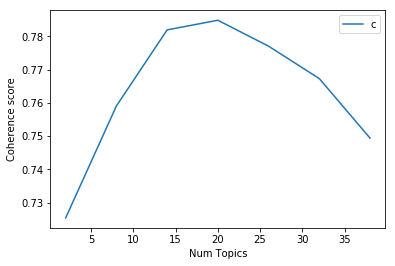

In [23]:
# show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values): # zip aggregate iterables (zero or more)
    print('Num Topics =', m, ' has Coherence Value of', round(cv, 4))
    # calls an iterated x (x = range(start, limit, step)) and coherence_values (4 decimals)

Num Topics = 2  has Coherence Value of 0.7254
Num Topics = 8  has Coherence Value of 0.7591
Num Topics = 14  has Coherence Value of 0.782
Num Topics = 20  has Coherence Value of 0.7849
Num Topics = 26  has Coherence Value of 0.7771
Num Topics = 32  has Coherence Value of 0.7673
Num Topics = 38  has Coherence Value of 0.7494


In [25]:
# Select the model with highest coherence value and print the topics
optimal_model = model_list[3] # the 3rd index from above output
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10)) # set num_words parament to show 10 words per topic

[(0,
  '0.282*"company" + 0.231*"people" + 0.077*"place" + 0.051*"grad" + '
  '0.026*"challenge" + 0.026*"compensation" + 0.026*"contract" + '
  '0.026*"progress" + 0.026*"smart" + 0.026*"intern"'),
 (1,
  '0.367*"company" + 0.102*"cloud" + 0.041*"strategist" + 0.041*"environment" '
  '+ 0.041*"employee" + 0.020*"pry" + 0.020*"usa" + 0.020*"break" + '
  '0.020*"atmosphere" + 0.020*"term"'),
 (2,
  '0.164*"review" + 0.164*"amazing" + 0.145*"senior" + 0.109*"job" + '
  '0.109*"balance" + 0.055*"great" + 0.036*"big" + 0.018*"compensation" + '
  '0.018*"java" + 0.018*"ep"'),
 (3,
  '0.333*"good" + 0.083*"review" + 0.083*"pay" + 0.062*"environment" + '
  '0.042*"senior" + 0.042*"outstanding" + 0.021*"depend" + 0.021*"point" + '
  '0.021*"hype" + 0.021*"worrying"'),
 (4,
  '0.314*"great" + 0.137*"program" + 0.078*"perk" + 0.059*"time" + '
  '0.059*"staff" + 0.039*"analytical" + 0.020*"technician" + 0.020*"average" + '
  '0.020*"coworker" + 0.020*"datum"'),
 (5,
  '0.530*"place" + 0.045*"perf

### Visual the Optimal LDA Mallet Model

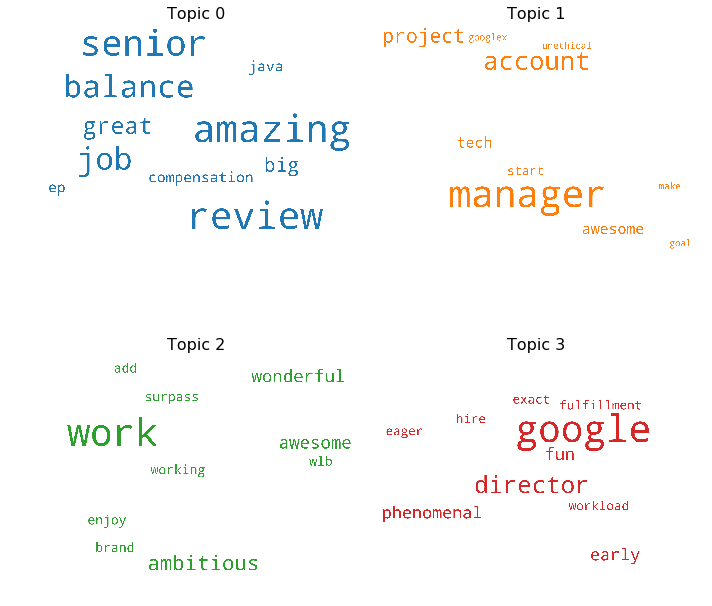

In [26]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Analysis

### Finding topics for each document

In [27]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Create DataFrame
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document
    for i, row in enumerate(ldamodel[corpus]):                   # call the optimal_model from LdaMallet (ldamodel=optimal_model)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)    # sort the dominant topic for each document (use row[0] for windows)
        
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:                                           # dominant topic
                wp = ldamodel.show_topic(topic_num)              # show the dominant topic column (topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])   # add keywords column to each dominant topic column
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                # add to dataframe columns: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)),
                # and keywords (topic_keywords)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'] # create dataframe title
    # Essentially, we sort the dominant topic for each document,
    # Then we add keywords column to each dominant topic column for each document, and append it to our sent_topics_df dataframe
    # (dataframe now include: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)), and keywords (topic_keywords))
    # Note that prop_topic is perc_contribution from output of keywords and their respective weights (ie. 'window', 0.0235866)
    # Finally name the dataframe columns for topic_num, prop_topic, topic_keywords to Dominant_topic, Perc_Contribution and Topic_Keywords
    
        
    # Add original text to the end of the output (recall that texts = data_lemmatized)
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    # we take out sent_topics_df dataframe that is configured, and add our texts to it

    
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
# texts=data since that is what we assigned in the format_topics_sentences function, but in the function we already
# called and added our data (texts=data_lemmatized) to the dataframe, which is why now we use texts=data default parameter


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()       # re-index
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']
# name all the columns for the DataFrame

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document
0,0,6.0,0.0577,"company, good, product, team, ad, depend, effe...",Best Company to work for
1,1,4.0,0.0798,"great, program, perk, time, staff, analytical,...",Moving at the speed of light burn out is inevi...
2,2,10.0,0.0731,"manager, account, project, tech, awesome, star...",Great balance between bigcompany security and ...
3,3,13.0,0.0648,"work, intern, analyst, internship, love, engin...",The best place Ive worked and also the most de...
4,4,11.0,0.0833,"software, dream, developer, data, meh, rough, ...",Unique one of a kind dream job
5,5,13.0,0.0723,"work, intern, analyst, internship, love, engin...",NICE working in GOOGLE as an INTERN
6,6,15.0,0.0630,"engineer, lead, experience, bad, stuff, teamma...",Software engineer
7,7,0.0,0.0628,"company, people, place, grad, challenge, compe...",great place to work and progress
8,8,14.0,0.0660,"work, ambitious, wonderful, awesome, add, wlb,...",Google Surpasses Realistic Expectations
9,9,15.0,0.0588,"engineer, lead, experience, bad, stuff, teamma...",Execellent for engineers


### Finding documents for each topic

In [28]:
# Group top 20 documents for the 20 dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame() # Create a new DataFrame for our analysis

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') 
# Groupyby dominant topics in df_topic_sents_keywords from above (where we derived the DataFrame showing dominant topic for each document)

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
# Take sent_topics_sorteddf_mallet DataFrame and combine it with,
# the most (head(1)) dominant topic in sent_topcs_outdf_grpd (grp) sort by perc_contribution
# Essentially, we take our dataset with dominant topics and group it with texts that has the most contribution for each dominant topic

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Document"]

# Show the top 20 documents for the 20 dominant topic
sent_topics_sorteddf_mallet 

,Topic_Num,Topic_Perc_Contrib,Keywords,Document
0,0.0,0.0804,"company, people, place, grad, challenge, compe...",Company full of people running around caring o...
1,1.0,0.0833,"company, cloud, strategist, environment, emplo...",I broke down crying on the datacenter floor
2,2.0,0.0717,"review, amazing, senior, job, balance, great, ...",Amazing place to develop technical skills
3,3.0,0.0744,"good, review, pay, environment, senior, outsta...",Good pay and work
4,4.0,0.0807,"great, program, perk, time, staff, analytical,...",Average with a hint of arrogance
5,5.0,0.0778,"place, perfect, technical, life, overpay, iii,...",Not perfect but still the best place in the wo...
6,6.0,0.0702,"company, good, product, team, ad, depend, effe...",Best Company in the world
7,7.0,0.0874,"great, benefit, excellent, product, lot, class...",Great benefits but large enough to get lost in
8,8.0,0.0713,"good, analyst, business, pgm, year, educator, ...",Good company with good benefits lots of red ta...
9,9.0,0.0828,"google, director, phenomenal, early, fun, fulf...",Early Childhood Educator


### Document distribution across Topics

In [29]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of overall Documents for Each Topic (round to 4 decimals)
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Total Dominant Topic Number
topic_num_keywords = {'Topic_Num': pd.Series([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,
                                              11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0])}
topic_num_keywords = pd.DataFrame(topic_num_keywords)
                      
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Reindex
df_dominant_topics.reset_index(drop=True, inplace=True)

# Change Column names
df_dominant_topics.columns = ['Dominant Topic', 'Num_Document', 'Perc_Document']

# Show
df_dominant_topics

,Dominant Topic,Num_Document,Perc_Document
0,0.0,35,0.070
1,1.0,32,0.064
2,2.0,20,0.040
3,3.0,24,0.048
4,4.0,27,0.054
5,5.0,35,0.070
6,6.0,19,0.038
7,7.0,17,0.034
8,8.0,22,0.044
9,9.0,33,0.066


## Answering the Questions

# Topics Analysis for Amazon

In [30]:
# Filters to Amazon only
dfam = df[df['company'] == 'amazon']

In [31]:
# Filters the data to the column needed for topic modeling
dfam = dfam[['summary']]
dfam.shape

(26430, 1)

26,430 dataset with 1 type

In [32]:
dfam = dfam.head(500)

## Data Cleansing

In [33]:
data = dfam['summary'].values.tolist() # convert to list

import re
data = [re.sub(r'[^a-zA-Z ]+', '', str(sent)) for sent in data] # removes everything except letters and space, str(sent) converts to string

In [34]:
from pprint import pprint
pprint(data[:1])

['An Amazing Place to Work']


## Pre-Processing

### Tokenization and Additional Cleansing

In [35]:
import gensim
from gensim.utils import simple_preprocess 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
        # deacc=True removes punctuations
        # simple_preprocess to tokenize, and clean up messy text (converts to lowercase and removes punctuations)
        
data_words = list(sent_to_words(data))

print(data_words[:1])   

[['an', 'amazing', 'place', 'to', 'work']]


### Remove Stopwords

In [36]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) # add additional stop words

# Define functions for stopwords, bigram, trigram and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # clean out words using simple_preprocess (gensim) if the words are not already in stop_words (stop_words from NLTK)
    
# Remove Stop Words from simple_preprocess
data_words_nostops = remove_stopwords(data_words)

### Create and Apply Trigrams

In [37]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# min_count is minimum 5 letters
# threshold is 100 threshold in each word before accepting another word

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_trigram(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Trigrams from Gensim.models.phrases
data_words_trigrams = make_trigram(data_words_nostops)

### Lemmatize

In [38]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): # http://spacy.io/api/annotation
    texts_out = [] # creates a list
    for sent in texts:
        doc = nlp(" ".join(sent)) # adds English dictionary from Spacy to the texts by instantiating doc
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
# adds doc to texts_out list for all base token in doc, if these added doc are from a loose part of the speech in allowed_postags
# in other words, every (base) word that comes in will be added to the list, if these (loose) words are a NOUN, ADJ, VERB, or ADV
# lemma_ is base form of token and pos_ is lose parts of the speech
    return texts_out

# texts -> doc -> token
# texts -> sent -> doc -> token

# Initialize spacy 'en' model, keeping only tagger components (for efficieny)
# python -m spacy download en
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['amazing', 'place', 'work']]


## Prepare Dictionary and Corpus

In [39]:
import gensim.corpora as corpora # dictionary

# Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [40]:
id2word[0]

'amazing'

In [41]:
# Human readable format of corpus (term-frequency) for the first item
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('amazing', 1), ('place', 1), ('work', 1)]]

## LDA Model

In [42]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics = 4, random_state = 100,
                                            update_every = 1, chunksize = 100, passes = 10, alpha = 'auto',
                                            per_word_topics=True)
# (corpus, dictionary, # of topics, random_state, how often the model parameters should be updated, # of document in each training chunk,
# total # of training passes, alpha is hyperparameter that affect sparsity of topics)
# Here we use 4 topics

# Print the keyword the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.095*"company" + 0.056*"work" + 0.050*"good" + 0.045*"software" + '
  '0.034*"engineer" + 0.021*"love" + 0.020*"development" + 0.018*"operation" + '
  '0.017*"fast" + 0.017*"awesome"'),
 (1,
  '0.104*"great" + 0.088*"work" + 0.059*"associate" + 0.053*"place" + '
  '0.042*"amazon" + 0.022*"pay" + 0.020*"not" + 0.019*"hard" + 0.019*"do" + '
  '0.017*"need"'),
 (2,
  '0.105*"manager" + 0.033*"bad" + 0.027*"opportunity" + 0.024*"area" + '
  '0.022*"customer" + 0.017*"account" + 0.015*"intern" + 0.015*"senior" + '
  '0.014*"service" + 0.014*"developer"'),
 (3,
  '0.068*"warehouse" + 0.057*"job" + 0.046*"associate" + 0.041*"experience" + '
  '0.038*"fulfillment" + 0.025*"assistant" + 0.023*"amazon" + 0.020*"process" '
  '+ 0.018*"culture" + 0.017*"time"')]


### LDA Model Performance

In [43]:
# Compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # A measure of how good the model is (lower the better)

# Compute coherence score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) # high the better


Perplexity:  -6.006126086233107

Coherence Score:  0.6674011109606927


### Visualize LDA Model

In [44]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # hides future warning

import pyLDAvis # interactive visualization for LDA
import pyLDAvis.gensim 

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.201050 -0.003497       1        1  33.489265
0      0.011348 -0.192684       2        1  22.803652
2      0.206619  0.021483       3        1  22.593195
3     -0.016917  0.174697       4        1  21.113890, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
26    Default  47.000000        great  47.000000  30.0000  30.0000
5     Default  32.000000      manager  32.000000  29.0000  29.0000
50    Default  29.000000      company  29.000000  28.0000  28.0000
2     Default  57.000000         work  57.000000  27.0000  27.0000
21    Default  19.000000    warehouse  19.000000  26.0000  26.0000
57    Default  16.000000          job  16.000000  25.0000  25.0000
1     Default  24.000000        place  24.000000  24.0000  24.0000
18    Default  40.000000    associate  40.000000  23.0000  23.0000
6     Default  14.000000     software  14.000000  22.0000  22.0000
81    Default  20.000000         good  20.000000  21.0000  21.0000
47    Default  12.000000   experience  12.000000  20.0000  20.0000
93    Default  11.000000  fulfillment  11.000000  19.0000  19.0000
73    Default  11.000000     engineer  11.000000  18.0000  18.0000
51    Default  26.000000       amazon  26.000000  17.0000  17.0000
131   Default  10.000000          bad  10.000000  16.0000  16.0000
59    Default   8.000000  opportunity   8.000000  15.0000  15.0000
32    Default   7.000000    assistant   7.000000  14.0000  14.0000
152   Default   8.000000         area   8.000000  13.0000  13.0000
190   Default   7.000000     customer   7.000000  12.0000  12.0000
39    Default   7.000000         love   7.000000  11.0000  11.0000
3     Default   6.000000  development   6.000000  10.0000  10.0000
246   Default   9.000000          not   9.000000   9.0000   9.0000
63    Default   6.000000      process   6.000000   8.0000   8.0000
37    Default   9.000000         hard   9.000000   7.0000   7.0000
30    Default   6.000000    operation   6.000000   6.0000   6.0000
245   Default   8.000000           do   8.000000   5.0000   5.0000
10    Default   5.000000      culture   5.000000   4.0000   4.0000
20    Default   5.000000         time   5.000000   3.0000   3.0000
169   Default  11.000000          pay  11.000000   2.0000   2.0000
108   Default   5.000000         fast   5.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
32     Topic4   7.265688    assistant   7.828942   1.4806  -3.6709
63     Topic4   5.614738      process   6.185545   1.4584  -3.9287
20     Topic4   4.988428         time   5.554035   1.4478  -4.0470
10     Topic4   5.083520      culture   5.663269   1.4472  -4.0281
52     Topic4   4.183041       worker   4.745273   1.4291  -4.2231
146    Topic4   3.832458       center   4.392593   1.4188  -4.3106
12     Topic4   3.759287     horrible   4.326889   1.4146  -4.3299
55     Topic4   3.524527       expect   4.100730   1.4038  -4.3944
140    Topic4   3.467290         ever   4.039882   1.4024  -4.4107
151    Topic4   3.187342      shopper   3.746590   1.3936  -4.4949
4      Topic4   3.040371  engineering   3.622205   1.3801  -4.5421
19     Topic4   2.583683         full   3.144714   1.3587  -4.7049
22     Topic4   2.397046         year   2.961794   1.3437  -4.7799
43     Topic4   2.294046           sr   2.858089   1.3354  -4.8238
130    Topic4   2.271632      politic   2.836548   1.3331  -4.8336
11     Topic4   2.307219     exciting   2.916304   1.3210  -4.8181
89     Topic4   2.045383        money   2.608807   1.3119  -4.9385
297    Topic4   2.004587         role   2.563791   1.3092  -4.9587
328    Topic4   1.921673    corporate   2.483567   1.2987  -5.0009
299    Topic4   1.691477       really   2.255694   1.2674  -5.1285
58     Topic4   1.578744          lot   2.147876   1.2474  -5.1975
183    Topic4  

## LDA Mallet Model

In [45]:
# Download file: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# Installing mallet: https://programminghistorian.org/en/lessons/topic-modeling-and-mallet#mac-instructions
# Download Java SE (download .zip instead of .exe for silent install)

import os
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'/Users/Mick/Desktop/mallet/'}) # set environment
mallet_path = '/Users/Mick/Desktop/mallet/bin/mallet' # update this path

In [46]:
ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=4,id2word=id2word)
# here we use 4 topics

In [47]:
# Show topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('work', 0.221875),
   ('great', 0.19375),
   ('company', 0.121875),
   ('environment', 0.03125),
   ('amazing', 0.028125),
   ('love', 0.025),
   ('senior', 0.021875),
   ('process', 0.021875),
   ('culture', 0.021875),
   ('time', 0.01875)]),
 (1,
  [('amazon', 0.1069182389937107),
   ('place', 0.1069182389937107),
   ('good', 0.07232704402515723),
   ('experience', 0.05345911949685535),
   ('bad', 0.03773584905660377),
   ('hard', 0.031446540880503145),
   ('opportunity', 0.025157232704402517),
   ('career', 0.018867924528301886),
   ('team', 0.018867924528301886),
   ('review', 0.018867924528301886)]),
 (2,
  [('manager', 0.15034965034965034),
   ('warehouse', 0.0979020979020979),
   ('pay', 0.04195804195804196),
   ('assistant', 0.03496503496503497),
   ('development', 0.03146853146853147),
   ('area', 0.03146853146853147),
   ('account', 0.024475524475524476),
   ('hour', 0.024475524475524476),
   ('decent', 0.02097902097902098),
   ('sde', 0.02097902097902098)]),
 (3,
  

### LDA Mallet Model Performance

In [48]:
# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.7114135883749362


## Finding the Optimal Number of Topics for LDA Mallet Model

In [49]:
# compute coherence_values for LdaMallets models

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model) # adds different LdaMallet models based on num_topics(start, limit, step)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence()) # add the different LdaMallet models and compute Coherence score
    return model_list, coherence_values

# Recall previous LdaMallet model
# ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=10,id2word=id2word)
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")

# compute a list of LdaMallets models
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

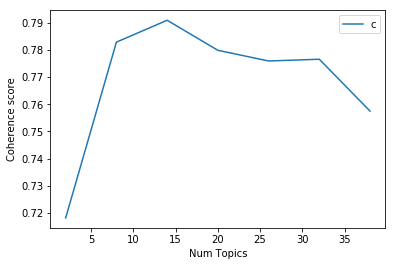

In [50]:
# show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [51]:
# Print the coherence scores
for m, cv in zip(x, coherence_values): # zip aggregate iterables (zero or more)
    print('Num Topics =', m, ' has Coherence Value of', round(cv, 4))
    # calls an iterated x (x = range(start, limit, step)) and coherence_values (4 decimals)

Num Topics = 2  has Coherence Value of 0.7182
Num Topics = 8  has Coherence Value of 0.7828
Num Topics = 14  has Coherence Value of 0.7909
Num Topics = 20  has Coherence Value of 0.7798
Num Topics = 26  has Coherence Value of 0.7759
Num Topics = 32  has Coherence Value of 0.7765
Num Topics = 38  has Coherence Value of 0.7575


In [52]:
# Select the model with highest coherence value and print the topics
optimal_model = model_list[2] # the 2nd index from above output
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10)) # set num_words parament to show 10 words per topic

[(0,
  '0.248*"place" + 0.208*"work" + 0.099*"associate" + 0.050*"account" + '
  '0.040*"engineering" + 0.030*"politic" + 0.020*"pick" + 0.020*"role" + '
  '0.010*"america" + 0.010*"scope"'),
 (1,
  '0.388*"amazon" + 0.094*"good" + 0.071*"fast" + 0.059*"review" + '
  '0.035*"product" + 0.024*"long" + 0.024*"management" + 0.024*"leqdrecruiter" '
  '+ 0.012*"divert" + 0.012*"student"'),
 (2,
  '0.280*"warehouse" + 0.120*"pay" + 0.100*"environment" + 0.060*"decent" + '
  '0.060*"love" + 0.050*"business" + 0.050*"sde" + 0.020*"stow" + '
  '0.020*"tough" + 0.020*"month"'),
 (3,
  '0.228*"work" + 0.089*"sortation" + 0.076*"learn" + 0.063*"hour" + '
  '0.038*"seasonal" + 0.038*"full" + 0.038*"horrible" + 0.025*"worth" + '
  '0.025*"money" + 0.013*"great"'),
 (4,
  '0.378*"work" + 0.085*"service" + 0.073*"senior" + 0.049*"year" + '
  '0.049*"dock" + 0.037*"executive" + 0.024*"benefit" + 0.012*"flexible" + '
  '0.012*"pickup" + 0.012*"friendly"'),
 (5,
  '0.280*"company" + 0.085*"hard" + 0.073*

### Visual the Optimal LDA Mallet Model

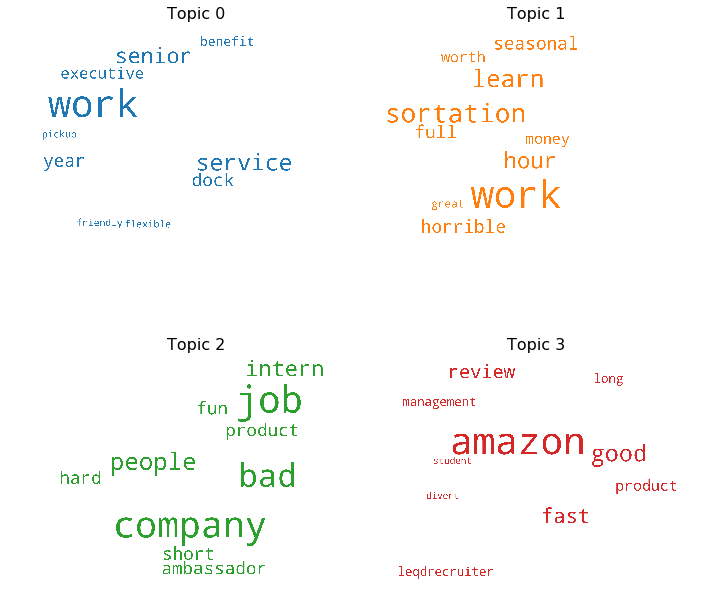

In [53]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Analysis

### Finding topics for each document

In [54]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Create DataFrame
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document
    for i, row in enumerate(ldamodel[corpus]):                   # call the optimal_model from LdaMallet (ldamodel=optimal_model)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)    # sort the dominant topic for each document (use row[0] for windows)
        
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:                                           # dominant topic
                wp = ldamodel.show_topic(topic_num)              # show the dominant topic column (topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])   # add keywords column to each dominant topic column
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                # add to dataframe columns: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)),
                # and keywords (topic_keywords)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'] # create dataframe title
    # Essentially, we sort the dominant topic for each document,
    # Then we add keywords column to each dominant topic column for each document, and append it to our sent_topics_df dataframe
    # (dataframe now include: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)), and keywords (topic_keywords))
    # Note that prop_topic is perc_contribution from output of keywords and their respective weights (ie. 'window', 0.0235866)
    # Finally name the dataframe columns for topic_num, prop_topic, topic_keywords to Dominant_topic, Perc_Contribution and Topic_Keywords
    
        
    # Add original text to the end of the output (recall that texts = data_lemmatized)
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    # we take out sent_topics_df dataframe that is configured, and add our texts to it

    
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
# texts=data since that is what we assigned in the format_topics_sentences function, but in the function we already
# called and added our data (texts=data_lemmatized) to the dataframe, which is why now we use texts=data default parameter


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()       # re-index
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']
# name all the columns for the DataFrame

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document
0,0,0.0,0.0925,"place, work, associate, account, engineering, ...",An Amazing Place to Work
1,1,11.0,0.1032,"experience, software, development, lot, develo...",Software Development Engineering Manager
2,2,12.0,0.0875,"fulfillment, associate, amazing, career, deman...",You Get What You Put In
3,3,13.0,0.0826,"good, culture, job, worker, center, crazy, cor...",Exciting Work Abusive Culture
4,4,3.0,0.0863,"work, sortation, learn, hour, seasonal, full, ...",Can be amazing for some people horrible for ot...
5,5,9.0,0.0883,"great, time, principal, sorter, pace, sr, team...",We are now in a world where we are condescende...
6,6,9.0,0.0851,"great, time, principal, sorter, pace, sr, team...",Warehouse associate full time for over two years
7,7,3.0,0.0802,"work, sortation, learn, hour, seasonal, full, ...",Great place to learn churn n burn culture in f...
8,8,6.0,0.0836,"manager, place, opportunity, great, team, deli...",Sr Product manager
9,9,10.0,0.0879,"associate, engineer, operation, seasonal, fina...",Central operations


### Finding documents for each topic

In [55]:
# Group top 14 documents for the 14 dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame() # Create a new DataFrame for our analysis

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') 
# Groupyby dominant topics in df_topic_sents_keywords from above (where we derived the DataFrame showing dominant topic for each document)

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
# Take sent_topics_sorteddf_mallet DataFrame and combine it with,
# the most (head(1)) dominant topic in sent_topcs_outdf_grpd (grp) sort by perc_contribution
# Essentially, we take our dataset with dominant topics and group it with texts that has the most contribution for each dominant topic

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Document"]

# Show the top 14 documents for the 14 dominant topic
sent_topics_sorteddf_mallet 

,Topic_Num,Topic_Perc_Contrib,Keywords,Document
0,0.0,0.1071,"place, work, associate, account, engineering, ...",Weird Politics
1,1.0,0.1071,"amazon, good, fast, review, product, long, man...",Amazon Advertising
2,2.0,0.1278,"warehouse, pay, environment, decent, love, bus...",Absolutely amazing Loved the working environm...
3,3.0,0.0958,"work, sortation, learn, hour, seasonal, full, ...",Diversity in the Reliability and Maintenance E...
4,4.0,0.0988,"work, service, senior, year, dock, executive, ...",I have been working at Amazon for years
5,5.0,0.1051,"company, hard, assistant, package, support, ch...",New Hired Sortation Professional
6,6.0,0.1071,"manager, place, opportunity, great, team, deli...",Opportunity After Opportunity
7,7.0,0.1196,"job, company, bad, people, intern, hard, short...",Great People Average Job
8,8.0,0.0991,"manager, customer, area, process, shopper, pic...",Run dont walk to Join The Team
9,9.0,0.1156,"great, time, principal, sorter, pace, sr, team...",GREAT GREAT GREAT


### Document distribution across Topics

In [56]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of overall Documents for Each Topic (round to 4 decimals)
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Total Dominant Topic Number
topic_num_keywords = {'Topic_Num': pd.Series([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,
                                              11.0,12.0,13.0])}
topic_num_keywords = pd.DataFrame(topic_num_keywords)
                      
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Reindex
df_dominant_topics.reset_index(drop=True, inplace=True)

# Change Column names
df_dominant_topics.columns = ['Dominant Topic', 'Num_Document', 'Perc_Document']

# Show
df_dominant_topics

,Dominant Topic,Num_Document,Perc_Document
0,0.0,61,0.122
1,1.0,41,0.082
2,2.0,57,0.114
3,3.0,25,0.050
4,4.0,27,0.054
5,5.0,31,0.062
6,6.0,22,0.044
7,7.0,34,0.068
8,8.0,38,0.076
9,9.0,39,0.078


## Answering the Questions

# Topics Analysis for Facebook

In [57]:
# Filters to Facebook only
dff = df[df['company'] == 'facebook']

In [58]:
# Filters the data to the column needed for topic modeling
dff = dff[['summary']]
dff.shape

(1590, 1)

1590 dataset with 1 type

In [59]:
dff = dff.head(500)

## Data Cleansing

In [60]:
data = dff['summary'].values.tolist() # convert to list

import re
data = [re.sub(r'[^a-zA-Z ]+', '', str(sent)) for sent in data] # removes everything except letters and space, str(sent) converts to string

In [61]:
from pprint import pprint
pprint(data[:1])

['nd Job out of college  Great Experience']


## Pre-Processing

### Tokenization and Additional Cleansing

In [62]:
import gensim
from gensim.utils import simple_preprocess 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
        # deacc=True removes punctuations
        # simple_preprocess to tokenize, and clean up messy text (converts to lowercase and removes punctuations)
        
data_words = list(sent_to_words(data))

print(data_words[:1])   

[['nd', 'job', 'out', 'of', 'college', 'great', 'experience']]


### Remove Stopwords

In [63]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) # add additional stop words

# Define functions for stopwords, bigram, trigram and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # clean out words using simple_preprocess (gensim) if the words are not already in stop_words (stop_words from NLTK)
    
# Remove Stop Words from simple_preprocess
data_words_nostops = remove_stopwords(data_words)

### Create and Apply Trigrams

In [64]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# min_count is minimum 5 letters
# threshold is 100 threshold in each word before accepting another word

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_trigram(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Trigrams from Gensim.models.phrases
data_words_trigrams = make_trigram(data_words_nostops)

### Lemmatize

In [65]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): # http://spacy.io/api/annotation
    texts_out = [] # creates a list
    for sent in texts:
        doc = nlp(" ".join(sent)) # adds English dictionary from Spacy to the texts by instantiating doc
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
# adds doc to texts_out list for all base token in doc, if these added doc are from a loose part of the speech in allowed_postags
# in other words, every (base) word that comes in will be added to the list, if these (loose) words are a NOUN, ADJ, VERB, or ADV
# lemma_ is base form of token and pos_ is lose parts of the speech
    return texts_out

# texts -> doc -> token
# texts -> sent -> doc -> token

# Initialize spacy 'en' model, keeping only tagger components (for efficieny)
# python -m spacy download en
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['job', 'college', 'great', 'experience']]


## Prepare Dictionary and Corpus

In [66]:
import gensim.corpora as corpora # dictionary

# Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [67]:
id2word[0]

'college'

In [68]:
# Human readable format of corpus (term-frequency) for the first item
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('college', 1), ('experience', 1), ('great', 1), ('job', 1)]]

## LDA Model

In [69]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics = 5, random_state = 100,
                                            update_every = 1, chunksize = 100, passes = 10, alpha = 'auto',
                                            per_word_topics=True)
# (corpus, dictionary, # of topics, random_state, how often the model parameters should be updated, # of document in each training chunk,
# total # of training passes, alpha is hyperparameter that affect sparsity of topics)
# Here we use 5 topics

# Print the keyword the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"job" + 0.036*"love" + 0.029*"people" + 0.026*"employee" + '
  '0.024*"fast" + 0.021*"benefit" + 0.020*"recruit" + 0.019*"move" + '
  '0.018*"fun" + 0.017*"impact"'),
 (1,
  '0.077*"facebook" + 0.060*"have" + 0.050*"ever" + 0.019*"lot" + '
  '0.018*"review" + 0.018*"workplace" + 0.017*"happy" + 0.014*"internship" + '
  '0.013*"office" + 0.012*"director"'),
 (2,
  '0.154*"work" + 0.122*"great" + 0.111*"place" + 0.099*"good" + '
  '0.083*"company" + 0.031*"amazing" + 0.031*"culture" + 0.017*"awesome" + '
  '0.016*"facebook" + 0.011*"operation"'),
 (3,
  '0.118*"engineer" + 0.092*"software" + 0.033*"growth" + 0.028*"product" + '
  '0.025*"challenge" + 0.024*"want" + 0.023*"technical" + 0.021*"never" + '
  '0.013*"value" + 0.012*"sourcer"'),
 (4,
  '0.060*"manager" + 0.039*"not" + 0.026*"ship" + 0.026*"big" + 0.020*"do" + '
  '0.019*"specialist" + 0.018*"get" + 0.017*"program" + 0.015*"still" + '
  '0.014*"imagine"')]


### LDA Model Performance

In [70]:
# Compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # A measure of how good the model is (lower the better)

# Compute coherence score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) # high the better


Perplexity:  -5.632439986151237

Coherence Score:  0.6616524474152321


### Visualize LDA Model

In [71]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # hides future warning

import pyLDAvis # interactive visualization for LDA
import pyLDAvis.gensim 

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.338506  0.012731       1        1  47.157734
0      0.083469 -0.169108       2        1  15.503798
1      0.057092 -0.039271       3        1  13.917659
3      0.106175  0.188278       4        1  12.604210
4      0.091770  0.007370       5        1  10.816601, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
38    Default  116.000000           work  116.000000  30.0000  30.0000
2     Default   92.000000          great   92.000000  29.0000  29.0000
14    Default   83.000000          place   83.000000  28.0000  28.0000
156   Default   24.000000       engineer   24.000000  27.0000  27.0000
37    Default   75.000000           good   75.000000  26.0000  26.0000
5     Default   63.000000        company   63.000000  25.0000  25.0000
107   Default   19.000000       software   19.000000  24.0000  24.0000
68    Default   29.000000       facebook   29.000000  23.0000  23.0000
152   Default   13.000000           have   13.000000  22.0000  22.0000
64    Default   10.000000        manager   10.000000  21.0000  21.0000
151   Default   11.000000           ever   11.000000  20.0000  20.0000
3     Default   12.000000            job   12.000000  19.0000  19.0000
36    Default    9.000000           love    9.000000  18.0000  18.0000
11    Default    7.000000            not    7.000000  17.0000  17.0000
52    Default    7.000000         growth    7.000000  16.0000  16.0000
13    Default    7.000000         people    7.000000  15.0000  15.0000
22    Default   24.000000        amazing   24.000000  14.0000  14.0000
89    Default   23.000000        culture   23.000000  13.0000  13.0000
35    Default    7.000000       employee    7.000000  12.0000  12.0000
160   Default    6.000000        product    6.000000  11.0000  11.0000
67    Default    7.000000      technical    7.000000  10.0000  10.0000
168   Default    5.000000      challenge    5.000000   9.0000   9.0000
8     Default    6.000000           fast    6.000000   8.0000   8.0000
462   Default    5.000000           ship    5.000000   7.0000   7.0000
125   Default    5.000000            big    5.000000   6.0000   6.0000
162   Default    5.000000           want    5.000000   5.0000   5.0000
50    Default    5.000000        benefit    5.000000   4.0000   4.0000
30    Default    5.000000        recruit    5.000000   3.0000   3.0000
167   Default    4.000000          never    4.000000   2.0000   2.0000
200   Default    5.000000           move    5.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
82     Topic5    3.341929     specialist    3.953266   2.0561  -3.9452
435    Topic5    3.108321            get    3.723914   2.0434  -4.0177
65     Topic5    2.999117        program    3.608720   2.0391  -4.0535
121    Topic5    2.567207          still    3.189687   2.0070  -4.2090
243    Topic5    2.462381        imagine    3.073696   2.0023  -4.2507
47     Topic5    2.345965        mission    2.959087   1.9919  -4.2991
242    Topic5    2.252910            can    2.863571   1.9842  -4.3396
389    Topic5    2.023595     phenomenal    2.633551   1.9606  -4.4469
423    Topic5    2.022831        diverse    2.633690   1.9602  -4.4473
427    Topic5    2.014353          could    2.635327   1.9554  -4.4515
346    Topic5    1.813863        project    2.423559   1.9343  -4.5563
347    Topic5    1.528800        content    2.139765   1.8879  -4.7273
259    Topic5    1.373606        excited    1.984634   1.8561  -4.8344
322    Topic5    1.319653      marketing    1.929483   1.8442  -4.8744
191    Topic5    1.337715           give    1.991306   1.8263  -4.8608
471    Topic5    1.211600      connected    1.829880   1.8118  -4.9599
260    Topic5    1.164704         expect    1.774316   1.8031  -4.9993
133    Topic5    1.050035    

## LDA Mallet Model

In [72]:
# Download file: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# Installing mallet: https://programminghistorian.org/en/lessons/topic-modeling-and-mallet#mac-instructions
# Download Java SE (download .zip instead of .exe for silent install)

import os
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'/Users/Mick/Desktop/mallet/'}) # create environment
mallet_path = '/Users/Mick/Desktop/mallet/bin/mallet' # update this path

In [73]:
ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=5,id2word=id2word)
# here we use 5 topics

In [74]:
# Show topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('great', 0.20955882352941177),
   ('company', 0.14338235294117646),
   ('job', 0.04779411764705882),
   ('growth', 0.04044117647058824),
   ('love', 0.03676470588235294),
   ('tech', 0.03308823529411765),
   ('recruit', 0.029411764705882353),
   ('challenge', 0.029411764705882353),
   ('team', 0.014705882352941176),
   ('balance', 0.014705882352941176)]),
 (1,
  [('work', 0.21678321678321677),
   ('facebook', 0.11538461538461539),
   ('culture', 0.0944055944055944),
   ('amazing', 0.05244755244755245),
   ('fast', 0.027972027972027972),
   ('benefit', 0.027972027972027972),
   ('career', 0.024475524475524476),
   ('big', 0.024475524475524476),
   ('recruiter', 0.017482517482517484),
   ('lot', 0.017482517482517484)]),
 (2,
  [('engineer', 0.12547528517110265),
   ('software', 0.09885931558935361),
   ('manager', 0.049429657794676805),
   ('technical', 0.03802281368821293),
   ('impact', 0.034220532319391636),
   ('employee', 0.034220532319391636),
   ('product', 0.026615969581

### LDA Mallet Model Performance

In [75]:
# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.7217056349778901


## Finding the Optimal Number of Topics for LDA Mallet Model

In [76]:
# compute coherence_values for LdaMallets models

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model) # adds different LdaMallet models based on num_topics(start, limit, step)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence()) # add the different LdaMallet models and compute Coherence score
    return model_list, coherence_values

# Recall previous LdaMallet model
# ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=10,id2word=id2word)
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")

# compute a list of LdaMallets models
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

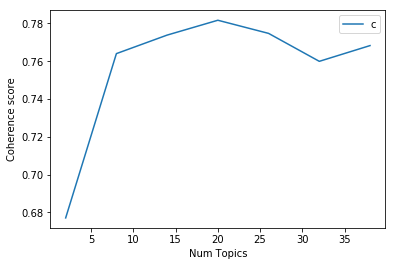

In [77]:
# show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [78]:
# Print the coherence scores
for m, cv in zip(x, coherence_values): # zip aggregate iterables (zero or more)
    print('Num Topics =', m, ' has Coherence Value of', round(cv, 4))
    # calls an iterated x (x = range(start, limit, step)) and coherence_values (4 decimals)

Num Topics = 2  has Coherence Value of 0.6771
Num Topics = 8  has Coherence Value of 0.764
Num Topics = 14  has Coherence Value of 0.7738
Num Topics = 20  has Coherence Value of 0.7817
Num Topics = 26  has Coherence Value of 0.7747
Num Topics = 32  has Coherence Value of 0.7599
Num Topics = 38  has Coherence Value of 0.7683


In [79]:
# Select the model with highest coherence value and print the topics
optimal_model = model_list[3] # the 3rd index from above output
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10)) # set num_words parament to show 10 words per topic

[(0,
  '0.593*"place" + 0.049*"hard" + 0.025*"positive" + 0.025*"worklife" + '
  '0.025*"hype" + 0.012*"news" + 0.012*"top" + 0.012*"vary" + 0.012*"enjoy" + '
  '0.012*"feel"'),
 (1,
  '0.675*"great" + 0.025*"contract" + 0.013*"passionate" + 0.013*"emotion" + '
  '0.013*"chaos" + 0.013*"contribution" + 0.013*"charge" + 0.013*"negative" + '
  '0.013*"innovative" + 0.013*"manager"'),
 (2,
  '0.377*"great" + 0.091*"work" + 0.078*"benefit" + 0.039*"sourcer" + '
  '0.039*"operation" + 0.026*"create" + 0.026*"perk" + 0.026*"love" + '
  '0.026*"move" + 0.026*"team"'),
 (3,
  '0.430*"place" + 0.063*"workplace" + 0.038*"excellent" + 0.038*"senior" + '
  '0.038*"incredible" + 0.025*"worth" + 0.025*"content" + 0.025*"drive" + '
  '0.013*"glassdoor" + 0.013*"specialist"'),
 (4,
  '0.299*"great" + 0.179*"job" + 0.104*"experience" + 0.045*"talent" + '
  '0.030*"corporate" + 0.015*"phenomenal" + 0.015*"impactful" + '
  '0.015*"autonomy" + 0.015*"balance" + 0.015*"positive"'),
 (5,
  '0.722*"work" + 0

### Visual the Optimal LDA Mallet Model

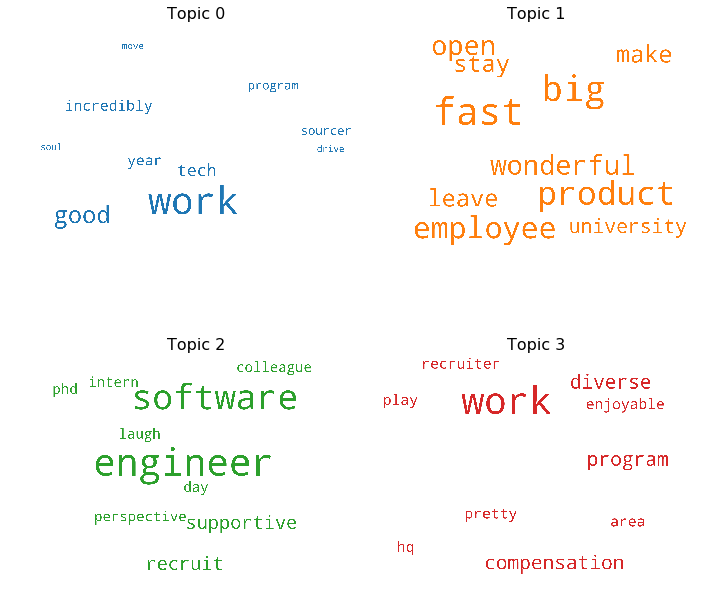

In [80]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Analysis

### Finding topics for each document

In [81]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Create DataFrame
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document
    for i, row in enumerate(ldamodel[corpus]):                   # call the optimal_model from LdaMallet (ldamodel=optimal_model)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)    # sort the dominant topic for each document (use row[0] for windows)
        
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:                                           # dominant topic
                wp = ldamodel.show_topic(topic_num)              # show the dominant topic column (topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])   # add keywords column to each dominant topic column
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                # add to dataframe columns: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)),
                # and keywords (topic_keywords)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'] # create dataframe title
    # Essentially, we sort the dominant topic for each document,
    # Then we add keywords column to each dominant topic column for each document, and append it to our sent_topics_df dataframe
    # (dataframe now include: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)), and keywords (topic_keywords))
    # Note that prop_topic is perc_contribution from output of keywords and their respective weights (ie. 'window', 0.0235866)
    # Finally name the dataframe columns for topic_num, prop_topic, topic_keywords to Dominant_topic, Perc_Contribution and Topic_Keywords
    
        
    # Add original text to the end of the output (recall that texts = data_lemmatized)
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    # we take out sent_topics_df dataframe that is configured, and add our texts to it

    
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
# texts=data since that is what we assigned in the format_topics_sentences function, but in the function we already
# called and added our data (texts=data_lemmatized) to the dataframe, which is why now we use texts=data default parameter


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()       # re-index
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']
# name all the columns for the DataFrame

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document
0,0,4.0,0.0772,"great, job, experience, talent, corporate, phe...",nd Job out of college Great Experience
1,1,18.0,0.0731,"fast, big, product, employee, wonderful, open,...",Fast paced company with high expectations but ...
2,2,14.0,0.0673,"company, awesome, culture, growth, limit, care...",Pleasantly Surprised
3,3,1.0,0.0673,"great, contract, passionate, emotion, chaos, c...",Dont believe all of the negative press
4,4,3.0,0.0660,"place, workplace, excellent, senior, incredibl...",Continues to be an amazing place to be
5,5,19.0,0.0962,"career, recruiter, start, lot, fantastic, lead...",AVOID FB incompetent management bias against w...
6,6,17.0,0.0643,"company, operation, fun, recruit, community, d...",Recruiting
7,7,14.0,0.0677,"company, awesome, culture, growth, limit, care...",Not for everyone high stress and company growi...
8,8,7.0,0.0673,"good, amazing, love, perk, office, interesting...",Loves its employees
9,9,1.0,0.0566,"great, contract, passionate, emotion, chaos, c...",Great company


### Finding documents for each topic

In [82]:
# Group top 20 documents for the 20 dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame() # Create a new DataFrame for our analysis

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') 
# Groupyby dominant topics in df_topic_sents_keywords from above (where we derived the DataFrame showing dominant topic for each document)

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
# Take sent_topics_sorteddf_mallet DataFrame and combine it with,
# the most (head(1)) dominant topic in sent_topcs_outdf_grpd (grp) sort by perc_contribution
# Essentially, we take our dataset with dominant topics and group it with texts that has the most contribution for each dominant topic

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Document"]

# Show the top 20 documents for the 20 dominant topic
sent_topics_sorteddf_mallet 

,Topic_Num,Topic_Perc_Contrib,Keywords,Document
0,0.0,0.0854,"place, hard, positive, worklife, hype, news, t...",Work hard play hard
1,1.0,0.0765,"great, contract, passionate, emotion, chaos, c...",Great compensation if you can cut it
2,2.0,0.0784,"great, work, benefit, sourcer, operation, crea...",Great benefits but mileage may vary depending ...
3,3.0,0.0764,"place, workplace, excellent, senior, incredibl...",Excellent place to start Meh place to stay
4,4.0,0.0833,"great, job, experience, talent, corporate, phe...",Great experience love my job
5,5.0,0.0694,"work, program, diverse, compensation, pretty, ...",Great perks good compensation but if you dont ...
6,6.0,0.0813,"good, bad, internship, employee, convert, find...",Obvious pros but cons are real
7,7.0,0.0843,"good, amazing, love, perk, office, interesting...",My worst day at Facebook is my best day at any...
8,8.0,0.0960,"engineer, software, recruit, supportive, inter...",Software Engineering PhD Intern Summer
9,9.0,0.0865,"facebook, environment, tech, grow, time, life,...",Facebook Environment


### Document distribution across Topics

In [83]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of overall Documents for Each Topic (round to 4 decimals)
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Total Dominant Topic Number
topic_num_keywords = {'Topic_Num': pd.Series([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,
                                              11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0])}
topic_num_keywords = pd.DataFrame(topic_num_keywords)
                      
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Reindex
df_dominant_topics.reset_index(drop=True, inplace=True)

# Change Column names
df_dominant_topics.columns = ['Dominant Topic', 'Num_Document', 'Perc_Document']

# Show
df_dominant_topics

,Dominant Topic,Num_Document,Perc_Document
0,0.0,41,0.082
1,1.0,29,0.058
2,2.0,16,0.032
3,3.0,26,0.052
4,4.0,24,0.048
5,5.0,15,0.030
6,6.0,39,0.078
7,7.0,22,0.044
8,8.0,40,0.080
9,9.0,29,0.058


## Answering the Questions

# Topics Analysis for Netflix

In [84]:
# Filters to Netflix only
dfn = df[df['company'] == 'netflix']

In [85]:
# Filters the data to the column needed for topic modeling
dfn = dfn[['summary']]
dfn.shape

(810, 1)

810 dataset with 1 type

In [86]:
dfn = dfn.head(500)

## Data Cleansing

In [87]:
data = dfn['summary'].values.tolist() # convert to list

import re
data = [re.sub(r'[^a-zA-Z ]+', '', str(sent)) for sent in data] # removes everything except letters and space, str(sent) converts to string

In [88]:
from pprint import pprint
pprint(data[:1])

['Executive Assistant']


## Pre-Processing

### Tokenization and Additional Cleansing

In [89]:
import gensim
from gensim.utils import simple_preprocess 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
        # deacc=True removes punctuations
        # simple_preprocess to tokenize, and clean up messy text (converts to lowercase and removes punctuations)
        
data_words = list(sent_to_words(data))

print(data_words[:1])   

[['executive', 'assistant']]


### Remove Stopwords

In [90]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) # add additional stop words

# Define functions for stopwords, bigram, trigram and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # clean out words using simple_preprocess (gensim) if the words are not already in stop_words (stop_words from NLTK)
    
# Remove Stop Words from simple_preprocess
data_words_nostops = remove_stopwords(data_words)

### Create and Apply Trigrams

In [91]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# min_count is minimum 5 letters
# threshold is 100 threshold in each word before accepting another word

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_trigram(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Trigrams from Gensim.models.phrases
data_words_trigrams = make_trigram(data_words_nostops)

### Lemmatize

In [92]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): # http://spacy.io/api/annotation
    texts_out = [] # creates a list
    for sent in texts:
        doc = nlp(" ".join(sent)) # adds English dictionary from Spacy to the texts by instantiating doc
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
# adds doc to texts_out list for all base token in doc, if these added doc are from a loose part of the speech in allowed_postags
# in other words, every (base) word that comes in will be added to the list, if these (loose) words are a NOUN, ADJ, VERB, or ADV
# lemma_ is base form of token and pos_ is lose parts of the speech
    return texts_out

# texts -> doc -> token
# texts -> sent -> doc -> token

# Initialize spacy 'en' model, keeping only tagger components (for efficieny)
# python -m spacy download en
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['executive', 'assistant']]


## Prepare Dictionary and Corpus

In [93]:
import gensim.corpora as corpora # dictionary

# Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [94]:
id2word[0]

'assistant'

In [95]:
# Human readable format of corpus (term-frequency) for the first item
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('assistant', 1), ('executive', 1)]]

## LDA Model

In [96]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics = 7, random_state = 100,
                                            update_every = 1, chunksize = 100, passes = 10, alpha = 'auto',
                                            per_word_topics=True)
# (corpus, dictionary, # of topics, random_state, how often the model parameters should be updated, # of document in each training chunk,
# total # of training passes, alpha is hyperparameter that affect sparsity of topics)
# Here we use 7 topics

# Print the keyword the 7 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.204*"great" + 0.160*"work" + 0.116*"place" + 0.090*"company" + '
  '0.047*"engineer" + 0.027*"culture" + 0.026*"software" + 0.023*"senior" + '
  '0.016*"people" + 0.008*"top"'),
 (1,
  '0.067*"high" + 0.066*"pay" + 0.048*"freedom" + 0.043*"fast" + '
  '0.034*"responsibility" + 0.031*"reward" + 0.021*"paced" + 0.018*"team" + '
  '0.018*"pressure" + 0.015*"worth"'),
 (2,
  '0.055*"customer" + 0.037*"make" + 0.034*"service" + 0.033*"culture" + '
  '0.031*"representative" + 0.027*"lot" + 0.025*"support" + 0.019*"be" + '
  '0.018*"csr" + 0.016*"opportunity"'),
 (3,
  '0.099*"netflix" + 0.072*"experience" + 0.053*"culture" + 0.043*"year" + '
  '0.033*"manager" + 0.026*"awesome" + 0.024*"supervisor" + 0.020*"excellent" '
  '+ 0.018*"management" + 0.016*"operation"'),
 (4,
  '0.082*"customer" + 0.075*"service" + 0.039*"much" + 0.029*"employee" + '
  '0.022*"assistant" + 0.015*"marketing" + 0.013*"competitive" + 0.013*"joke" '
  '+ 0.012*"focus" + 0.011*"cost"'),
 (5,
  '0.120*"good" 

### LDA Model Performance

In [97]:
# Compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # A measure of how good the model is (lower the better)

# Compute coherence score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) # high the better


Perplexity:  -6.063769839232722

Coherence Score:  0.6387266805783481


### Visualize LDA Model

In [98]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # hides future warning

import pyLDAvis # interactive visualization for LDA
import pyLDAvis.gensim 

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.349140 -0.008089       1        1  27.486267
5      0.052154  0.297635       2        1  19.492601
3      0.033393 -0.047336       3        1  13.694482
1      0.076997 -0.096572       4        1  12.355272
2      0.061536 -0.042282       5        1  10.763803
4      0.078447 -0.060025       6        1   8.427506
6      0.046612 -0.043332       7        1   7.780066, topic_info=     Category       Freq            Term      Total  loglift  logprob
term                                                                 
12    Default  88.000000           great  88.000000  30.0000  30.0000
42    Default  69.000000            work  69.000000  29.0000  29.0000
43    Default  50.000000           place  50.000000  28.0000  28.0000
39    Default  37.000000            good  37.000000  27.0000  27.0000
11    Default  39.000000         company  39.000000  26.0000  26.0000
9     Default  23.000000         netflix  23.000000  25.0000  25.0000
33    Default  20.000000        customer  20.000000  24.0000  24.0000
132   Default  20.000000             job  20.000000  23.0000  23.0000
89    Default  16.000000      experience  16.000000  22.0000  22.0000
34    Default  16.000000         service  16.000000  21.0000  21.0000
219   Default  13.000000            high  13.000000  20.0000  20.0000
41    Default  13.000000             pay  13.000000  19.0000  19.0000
84    Default  20.000000        engineer  20.000000  18.0000  18.0000
144   Default  14.000000     environment  14.000000  17.0000  17.0000
135   Default   9.000000         freedom   9.000000  16.0000  16.0000
18    Default  34.000000         culture  34.000000  15.0000  15.0000
120   Default   9.000000            year   9.000000  14.0000  14.0000
78    Default  12.000000            call  12.000000  13.0000  13.0000
206   Default   8.000000            fast   8.000000  12.0000  12.0000
79    Default  10.000000          center  10.000000  11.0000  11.0000
166   Default   6.000000            make   6.000000  10.0000  10.0000
15    Default   7.000000         manager   7.000000   9.0000   9.0000
136   Default   7.000000  responsibility   7.000000   8.0000   8.0000
116   Default   5.000000         amazing   5.000000   7.0000   7.0000
5     Default   5.000000            much   5.000000   6.0000   6.0000
56    Default   9.000000             bad   9.000000   5.0000   5.0000
331   Default   6.000000          reward   6.000000   4.0000   4.0000
130   Default   5.000000  representative   5.000000   3.0000   3.0000
225   Default   9.000000          people   9.000000   2.0000   2.0000
86    Default  11.000000        software  11.000000   1.0000   1.0000
...       ...        ...             ...        ...      ...      ...
127    Topic7   1.937733         finance   2.549792   2.2791  -4.1405
112    Topic7   1.937972        everyone   2.550293   2.2790  -4.1404
390    Topic7   1.831418            easy   2.443676   2.2652  -4.1969
265    Topic7   1.781457           smart   2.393602   2.2582  -4.2246
53     Topic7   1.744712         analyst   2.356642   2.2530  -4.2454
126    Topic7   1.675724        business   2.287829   2.2422  -4.2858
163    Topic7   1.389373          manage   2.001295   2.1887  -4.4732
134    Topic7   1.388656       workplace   2.001341   2.1881  -4.4737
165    Topic7   1.386191            perk   2.001769   2.1861  -4.4755
111    Topic7   1.090324         benefit   1.702468   2.1080  -4.7156
484    Topic7   1.089604            live   1.701514   2.1079  -4.7162
518    Topic7   1.089604     accordingly   1.701514   2.1079  -4.7162
519    Topic7   1.089604            know   1.701514   2.1079  -4.7162
520    Topic7   1.089604            path   1.701514   2.1079  -4.7162
485    Topic7   1.089604             mba   1.701514   2.1079  -4.7162
483    Topic7   1.089604            case   1.701514   2.1079  -4.7162
486    Topic7   1.089604           study 

## LDA Mallet Model

In [99]:
# Download file: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# Installing mallet: https://programminghistorian.org/en/lessons/topic-modeling-and-mallet#mac-instructions
# Download Java SE (download .zip instead of .exe for silent install)

import os
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'/Users/Mick/Desktop/mallet/'}) # create environment
mallet_path = '/Users/Mick/Desktop/mallet/bin/mallet' # update this path

In [100]:
ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=7,id2word=id2word)
# here we use 7 topics

In [101]:
# Show topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('engineer', 0.12435233160621761),
   ('software', 0.07253886010362694),
   ('senior', 0.07253886010362694),
   ('love', 0.05181347150259067),
   ('amazing', 0.05181347150259067),
   ('company', 0.04145077720207254),
   ('supervisor', 0.03626943005181347),
   ('production', 0.025906735751295335),
   ('lot', 0.025906735751295335),
   ('paced', 0.02072538860103627)]),
 (1,
  [('netflix', 0.15813953488372093),
   ('place', 0.08372093023255814),
   ('work', 0.06511627906976744),
   ('environment', 0.06046511627906977),
   ('people', 0.05116279069767442),
   ('year', 0.04186046511627907),
   ('csr', 0.027906976744186046),
   ('support', 0.027906976744186046),
   ('operation', 0.023255813953488372),
   ('team', 0.018604651162790697)]),
 (2,
  [('work', 0.26785714285714285),
   ('place', 0.16964285714285715),
   ('company', 0.07589285714285714),
   ('make', 0.03125),
   ('top', 0.017857142857142856),
   ('competitive', 0.013392857142857142),
   ('finance', 0.013392857142857142),
   ('

### LDA Mallet Model Performance

In [102]:
# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.7503270215467082


## Finding the Optimal Number of Topics for LDA Mallet Model

In [103]:
# compute coherence_values for LdaMallets models

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model) # adds different LdaMallet models based on num_topics(start, limit, step)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence()) # add the different LdaMallet models and compute Coherence score
    return model_list, coherence_values

# Recall previous LdaMallet model
# ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=10,id2word=id2word)
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")

# compute a list of LdaMallets models
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

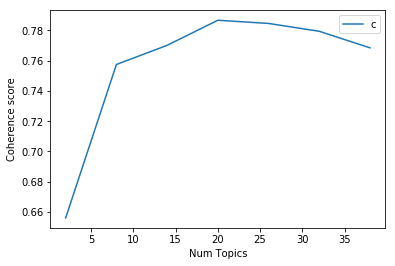

In [104]:
# show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [105]:
# Print the coherence scores
for m, cv in zip(x, coherence_values): # zip aggregate iterables (zero or more)
    print('Num Topics =', m, ' has Coherence Value of', round(cv, 4))
    # calls an iterated x (x = range(start, limit, step)) and coherence_values (4 decimals)

Num Topics = 2  has Coherence Value of 0.6561
Num Topics = 8  has Coherence Value of 0.7574
Num Topics = 14  has Coherence Value of 0.7701
Num Topics = 20  has Coherence Value of 0.7867
Num Topics = 26  has Coherence Value of 0.7846
Num Topics = 32  has Coherence Value of 0.7794
Num Topics = 38  has Coherence Value of 0.7684


In [106]:
# Select the model with highest coherence value and print the topics
optimal_model = model_list[3] # the 3rd index from above output
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10)) # set num_words parament to show 10 words per topic

[(0,
  '0.268*"job" + 0.141*"love" + 0.056*"rep" + 0.042*"excellent" + 0.028*"hour" '
  '+ 0.028*"leadership" + 0.028*"reliability" + 0.028*"focus" + 0.028*"fine" + '
  '0.014*"deal"'),
 (1,
  '0.362*"netflix" + 0.072*"management" + 0.058*"pace" + 0.043*"enjoyable" + '
  '0.029*"assistant" + 0.029*"quick" + 0.029*"stressful" + 0.014*"hit" + '
  '0.014*"awesome" + 0.014*"sustain"'),
 (2,
  '0.177*"work" + 0.113*"fear" + 0.081*"assistant" + 0.065*"top" + '
  '0.065*"team" + 0.048*"product" + 0.048*"talent" + 0.032*"high" + '
  '0.032*"pretty" + 0.032*"density"'),
 (3,
  '0.452*"culture" + 0.041*"amazing" + 0.041*"smart" + 0.041*"turnover" + '
  '0.027*"interesting" + 0.014*"matrix" + 0.014*"job" + 0.014*"path" + '
  '0.014*"developer" + 0.014*"startup"'),
 (4,
  '0.457*"great" + 0.074*"csr" + 0.049*"operation" + 0.049*"nice" + '
  '0.037*"technical" + 0.037*"balance" + 0.037*"solid" + 0.025*"treat" + '
  '0.012*"deck" + 0.012*"incredible"'),
 (5,
  '0.231*"high" + 0.138*"netflix" + 0.046

### Visual the Optimal LDA Mallet Model

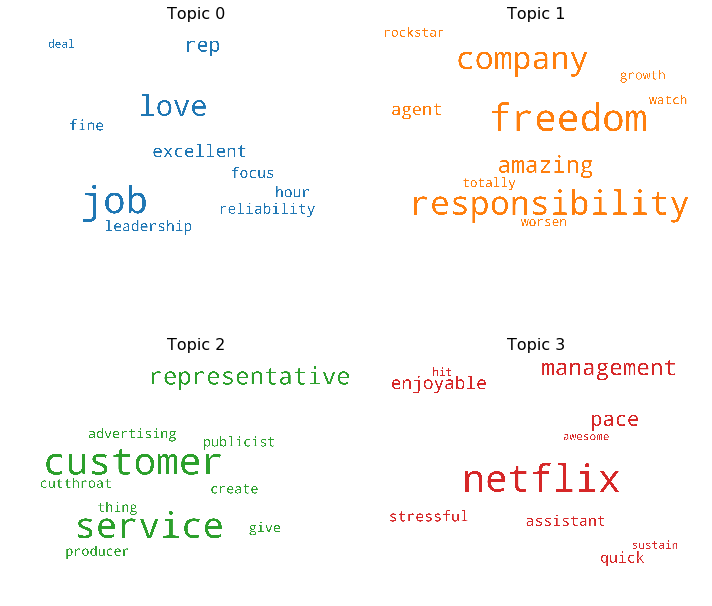

In [107]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Analysis

### Finding topics for each document

In [108]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Create DataFrame
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document
    for i, row in enumerate(ldamodel[corpus]):                   # call the optimal_model from LdaMallet (ldamodel=optimal_model)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)    # sort the dominant topic for each document (use row[0] for windows)
        
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:                                           # dominant topic
                wp = ldamodel.show_topic(topic_num)              # show the dominant topic column (topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])   # add keywords column to each dominant topic column
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                # add to dataframe columns: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)),
                # and keywords (topic_keywords)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'] # create dataframe title
    # Essentially, we sort the dominant topic for each document,
    # Then we add keywords column to each dominant topic column for each document, and append it to our sent_topics_df dataframe
    # (dataframe now include: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)), and keywords (topic_keywords))
    # Note that prop_topic is perc_contribution from output of keywords and their respective weights (ie. 'window', 0.0235866)
    # Finally name the dataframe columns for topic_num, prop_topic, topic_keywords to Dominant_topic, Perc_Contribution and Topic_Keywords
    
        
    # Add original text to the end of the output (recall that texts = data_lemmatized)
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    # we take out sent_topics_df dataframe that is configured, and add our texts to it

    
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
# texts=data since that is what we assigned in the format_topics_sentences function, but in the function we already
# called and added our data (texts=data_lemmatized) to the dataframe, which is why now we use texts=data default parameter


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()       # re-index
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']
# name all the columns for the DataFrame

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document
0,0,2.0,0.0609,"work, fear, assistant, top, team, product, tal...",Executive Assistant
1,1,5.0,0.0618,"high, netflix, lot, reward, worklife, enjoy, p...",How much does a functioning human cost
2,2,12.0,0.0673,"good, center, call, business, performance, pro...",QA Tester Contractor
3,3,0.0,0.0673,"job, love, rep, excellent, hour, leadership, r...",Netflix Editor
4,4,0.0,0.0664,"job, love, rep, excellent, hour, leadership, r...",I love it
5,5,0.0,0.0500,"job, love, rep, excellent, hour, leadership, r...",Ok
6,6,15.0,0.0628,"pay, manager, grow, employee, challenge, custo...",Great company with some growing pains
7,7,4.0,0.0673,"great, csr, operation, nice, technical, balanc...",Operations Manager
8,8,3.0,0.0719,"culture, amazing, smart, turnover, interesting...",Culture of fear is real tone deaf culture that...
9,9,18.0,0.0599,"engineer, software, senior, opportunity, handl...",Very friendly


### Finding documents for each topic

In [109]:
# Group top 20 documents for the 20 dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame() # Create a new DataFrame for our analysis

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') 
# Groupyby dominant topics in df_topic_sents_keywords from above (where we derived the DataFrame showing dominant topic for each document)

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
# Take sent_topics_sorteddf_mallet DataFrame and combine it with,
# the most (head(1)) dominant topic in sent_topcs_outdf_grpd (grp) sort by perc_contribution
# Essentially, we take our dataset with dominant topics and group it with texts that has the most contribution for each dominant topic

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Document"]

# Show the top 20 documents for the 20 dominant topic
sent_topics_sorteddf_mallet 

,Topic_Num,Topic_Perc_Contrib,Keywords,Document
0,0.0,0.0854,"job, love, rep, excellent, hour, leadership, r...",I loved it thought it was very easy and I love...
1,1.0,0.0798,"netflix, management, pace, enjoyable, assistan...",great spot to make a quick buck
2,2.0,0.1039,"work, fear, assistant, top, team, product, tal...",Top Talent Top Comany
3,3.0,0.0903,"culture, amazing, smart, turnover, interesting...",Global Learning and Development Curriculum Dev...
4,4.0,0.0813,"great, csr, operation, nice, technical, balanc...",Great job People were very nice
5,5.0,0.0957,"high, netflix, lot, reward, worklife, enjoy, p...",High Pressure High Reward
6,6.0,0.0813,"place, bad, marketing, content, excellent, pos...",Great place to work could use some more diversity
7,7.0,0.0849,"place, work, paced, senior, change, job, benef...",Senior Financial Analyst
8,8.0,0.0942,"work, technology, review, demand, enemy, payab...",Netflix is the same as working for HBOTime War...
9,9.0,0.0798,"culture, good, production, fantastic, worth, r...",A culture of high performance can be daunting ...


### Document distribution across Topics

In [110]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of overall Documents for Each Topic (round to 4 decimals)
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Total Dominant Topic Number
topic_num_keywords = {'Topic_Num': pd.Series([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,
                                              11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0])}
topic_num_keywords = pd.DataFrame(topic_num_keywords)
                      
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Reindex
df_dominant_topics.reset_index(drop=True, inplace=True)

# Change Column names
df_dominant_topics.columns = ['Dominant Topic', 'Num_Document', 'Perc_Document']

# Show
df_dominant_topics

,Dominant Topic,Num_Document,Perc_Document
0,0.0,60,0.120
1,1.0,36,0.072
2,2.0,22,0.044
3,3.0,22,0.044
4,4.0,21,0.042
5,5.0,15,0.030
6,6.0,29,0.058
7,7.0,26,0.052
8,8.0,23,0.046
9,9.0,19,0.038


## Answering the Questions

# Topics Analysis for Apple

In [111]:
# Filters to Apple only
dfap = df[df['company'] == 'apple']

In [112]:
# Filters the data to the column needed for topic modeling
dfap = dfap[['summary']]
dfap.shape

(12950, 1)

12,950 dataset with 1 type

In [113]:
dfap = dfap.head(500)

## Data Cleansing

In [114]:
data = dfap['summary'].values.tolist() # convert to list

import re
data = [re.sub(r'[^a-zA-Z ]+', '', str(sent)) for sent in data] # removes everything except letters and space, str(sent) converts to string

In [115]:
from pprint import pprint
pprint(data[:1])

['GIS  Data Analyst']


## Pre-Processing

### Tokenization and Additional Cleansing

In [116]:
import gensim
from gensim.utils import simple_preprocess 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
        # deacc=True removes punctuations
        # simple_preprocess to tokenize, and clean up messy text (converts to lowercase and removes punctuations)
        
data_words = list(sent_to_words(data))

print(data_words[:1])   

[['gis', 'data', 'analyst']]


### Remove Stopwords

In [117]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) # add additional stop words

# Define functions for stopwords, bigram, trigram and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # clean out words using simple_preprocess (gensim) if the words are not already in stop_words (stop_words from NLTK)
    
# Remove Stop Words from simple_preprocess
data_words_nostops = remove_stopwords(data_words)

### Create and Apply Trigrams

In [118]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# min_count is minimum 5 letters
# threshold is 100 threshold in each word before accepting another word

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_trigram(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Trigrams from Gensim.models.phrases
data_words_trigrams = make_trigram(data_words_nostops)

### Lemmatize

In [119]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): # http://spacy.io/api/annotation
    texts_out = [] # creates a list
    for sent in texts:
        doc = nlp(" ".join(sent)) # adds English dictionary from Spacy to the texts by instantiating doc
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
# adds doc to texts_out list for all base token in doc, if these added doc are from a loose part of the speech in allowed_postags
# in other words, every (base) word that comes in will be added to the list, if these (loose) words are a NOUN, ADJ, VERB, or ADV
# lemma_ is base form of token and pos_ is lose parts of the speech
    return texts_out

# texts -> doc -> token
# texts -> sent -> doc -> token

# Initialize spacy 'en' model, keeping only tagger components (for efficieny)
# python -m spacy download en
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['data', 'analyst']]


## Prepare Dictionary and Corpus

In [120]:
import gensim.corpora as corpora # dictionary

# Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [121]:
id2word[0]

'analyst'

In [122]:
# Human readable format of corpus (term-frequency) for the first item
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('analyst', 1), ('data', 1)]]

## LDA Model

In [123]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics = 6, random_state = 100,
                                            update_every = 1, chunksize = 100, passes = 10, alpha = 'auto',
                                            per_word_topics=True)
# (corpus, dictionary, # of topics, random_state, how often the model parameters should be updated, # of document in each training chunk,
# total # of training passes, alpha is hyperparameter that affect sparsity of topics)
# Here we use 6 topics

# Print the keyword the 6 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.095*"manager" + 0.061*"senior" + 0.046*"sale" + 0.046*"product" + '
  '0.043*"business" + 0.029*"program" + 0.026*"awesome" + 0.021*"poor" + '
  '0.015*"many" + 0.013*"zone"'),
 (1,
  '0.069*"engineer" + 0.052*"amazing" + 0.043*"software" + 0.036*"make" + '
  '0.031*"store" + 0.024*"applecare" + 0.022*"management" + 0.019*"time" + '
  '0.016*"excellent" + 0.016*"get"'),
 (2,
  '0.260*"specialist" + 0.119*"technical" + 0.054*"support" + 0.051*"tech" + '
  '0.043*"expert" + 0.026*"still" + 0.023*"career" + 0.021*"fun" + '
  '0.012*"operation" + 0.012*"chat"'),
 (3,
  '0.132*"good" + 0.126*"company" + 0.091*"great" + 0.070*"job" + '
  '0.066*"advisor" + 0.040*"home" + 0.033*"genius" + 0.032*"college" + '
  '0.017*"overall" + 0.015*"bad"'),
 (4,
  '0.127*"work" + 0.117*"great" + 0.101*"apple" + 0.086*"retail" + '
  '0.078*"place" + 0.035*"review" + 0.035*"experience" + 0.029*"culture" + '
  '0.019*"people" + 0.018*"environment"'),
 (5,
  '0.044*"love" + 0.041*"apple" + 0.023*"loo

### LDA Model Performance

In [124]:
# Compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # A measure of how good the model is (lower the better)

# Compute coherence score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) # high the better


Perplexity:  -5.673120273053418

Coherence Score:  0.676246057382714


### Visualize LDA Model

In [125]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # hides future warning

import pyLDAvis # interactive visualization for LDA
import pyLDAvis.gensim 

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.228752 -0.206570       1        1  26.161592
4      0.190130  0.183545       2        1  25.372278
2     -0.175871 -0.133163       3        1  14.657826
1     -0.089478  0.049793       4        1  13.194354
5     -0.053815  0.087166       5        1  10.666625
0     -0.099717  0.019230       6        1   9.947322, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
56    Default  50.000000   specialist  50.000000  30.0000  30.0000
15    Default  45.000000         good  45.000000  29.0000  29.0000
22    Default  42.000000         work  42.000000  28.0000  28.0000
11    Default  43.000000      company  43.000000  27.0000  27.0000
20    Default  70.000000        great  70.000000  26.0000  26.0000
59    Default  23.000000    technical  23.000000  25.0000  25.0000
16    Default  39.000000        apple  39.000000  24.0000  24.0000
38    Default  29.000000       retail  29.000000  23.0000  23.0000
21    Default  26.000000        place  26.000000  22.0000  22.0000
23    Default  12.000000      manager  12.000000  21.0000  21.0000
6     Default  24.000000          job  24.000000  20.0000  20.0000
26    Default  23.000000      advisor  23.000000  19.0000  19.0000
136   Default  12.000000     engineer  12.000000  18.0000  18.0000
121   Default  11.000000      support  11.000000  17.0000  17.0000
24    Default   8.000000       senior   8.000000  16.0000  16.0000
66    Default  10.000000         tech  10.000000  15.0000  15.0000
186   Default   9.000000      amazing   9.000000  14.0000  14.0000
27    Default  14.000000         home  14.000000  13.0000  13.0000
60    Default   8.000000       expert   8.000000  12.0000  12.0000
115   Default   8.000000     software   8.000000  11.0000  11.0000
31    Default   6.000000         sale   6.000000  10.0000  10.0000
13    Default   6.000000      product   6.000000   9.0000   9.0000
43    Default   6.000000         love   6.000000   8.0000   8.0000
29    Default  12.000000       review  12.000000   7.0000   7.0000
18    Default  12.000000   experience  12.000000   6.0000   6.0000
30    Default   6.000000     business   6.000000   5.0000   5.0000
17    Default  11.000000       genius  11.000000   4.0000   4.0000
174   Default   6.000000         make   6.000000   3.0000   3.0000
51    Default  11.000000      college  11.000000   2.0000   2.0000
32    Default  10.000000      culture  10.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
13     Topic6   5.926046      product   6.560751   2.2061  -3.0883
30     Topic6   5.583932     business   6.218524   2.2002  -3.1477
64     Topic6   3.716615      program   4.350407   2.1504  -3.5548
42     Topic6   3.399529      awesome   4.034017   2.1367  -3.6440
110    Topic6   2.691943         poor   3.328446   2.0956  -3.8774
312    Topic6   1.988797         many   2.622804   2.0312  -4.1801
196    Topic6   1.625510         zone   2.260108   1.9783  -4.3818
83     Topic6   1.512398  engineering   2.146121   1.9579  -4.4539
84     Topic6   1.230167        group   1.863886   1.8924  -4.6605
353    Topic6   1.189342    corporate   1.823117   1.8807  -4.6942
377    Topic6   1.189342        layer   1.823117   1.8807  -4.6942
383    Topic6   1.189342         back   1.823117   1.8807  -4.6942
354    Topic6   1.189342    departure   1.823117   1.8807  -4.6942
384    Topic6   1.189342        house   1.823117   1.8807  -4.6942
385    Topic6   1.189342        clean   1.823117   1.8807  -4.6942
386    Topic6   1.189342          kbs   1.823117   1.8807  -4.6942
355    Topic6   1.189203     parttime   1.823074   1.8806  -4.6943
357    Topic6   1.186875          red   1.823341   1.8785  -4.6963
86     Topic6   1.021429      politic   1.655364   1.8250  -4.8464
300    Topic6   0.907175       supply   1

## LDA Mallet Model

In [126]:
# Download file: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# Installing mallet: https://programminghistorian.org/en/lessons/topic-modeling-and-mallet#mac-instructions
# Download Java SE (download .zip instead of .exe for silent install)

import os
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'/Users/Mick/Desktop/mallet/'}) # create environment
mallet_path = '/Users/Mick/Desktop/mallet/bin/mallet' # update this path

In [127]:
ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=6,id2word=id2word)
# here we use 6 topics

In [128]:
# Show topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('specialist', 0.3076923076923077),
   ('technical', 0.13122171945701358),
   ('job', 0.11312217194570136),
   ('engineer', 0.06787330316742081),
   ('time', 0.03619909502262444),
   ('make', 0.027149321266968326),
   ('excellent', 0.01809954751131222),
   ('outstanding', 0.013574660633484163),
   ('family', 0.013574660633484163),
   ('cool', 0.013574660633484163)]),
 (1,
  [('great', 0.19902912621359223),
   ('manager', 0.0970873786407767),
   ('experience', 0.06310679611650485),
   ('tech', 0.06310679611650485),
   ('product', 0.04854368932038835),
   ('college', 0.04854368932038835),
   ('people', 0.038834951456310676),
   ('awesome', 0.03398058252427184),
   ('challenge', 0.019417475728155338),
   ('poor', 0.019417475728155338)]),
 (2,
  [('apple', 0.25252525252525254),
   ('genius', 0.08080808080808081),
   ('review', 0.06565656565656566),
   ('love', 0.050505050505050504),
   ('bad', 0.03535353535353535),
   ('environment', 0.03535353535353535),
   ('retail', 0.0303030303

### LDA Mallet Model Performance

In [129]:
# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.7420220709632819


## Finding the Optimal Number of Topics for LDA Mallet Model

In [130]:
# compute coherence_values for LdaMallets models

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model) # adds different LdaMallet models based on num_topics(start, limit, step)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence()) # add the different LdaMallet models and compute Coherence score
    return model_list, coherence_values

# Recall previous LdaMallet model
# ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=10,id2word=id2word)
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")

# compute a list of LdaMallets models
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

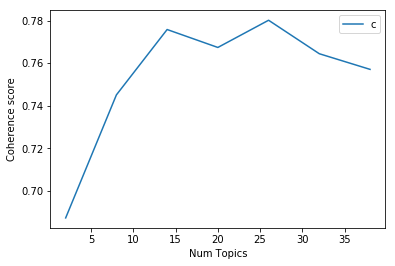

In [131]:
# show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [132]:
# Print the coherence scores
for m, cv in zip(x, coherence_values): # zip aggregate iterables (zero or more)
    print('Num Topics =', m, ' has Coherence Value of', round(cv, 4))
    # calls an iterated x (x = range(start, limit, step)) and coherence_values (4 decimals)

Num Topics = 2  has Coherence Value of 0.6872
Num Topics = 8  has Coherence Value of 0.745
Num Topics = 14  has Coherence Value of 0.7758
Num Topics = 20  has Coherence Value of 0.7674
Num Topics = 26  has Coherence Value of 0.7801
Num Topics = 32  has Coherence Value of 0.7644
Num Topics = 38  has Coherence Value of 0.7571


In [133]:
# Select the model with highest coherence value and print the topics
optimal_model = model_list[4] # the 4th index from above output
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10)) # set num_words parament to show 10 words per topic

[(25,
  '0.222*"culture" + 0.178*"expert" + 0.178*"sale" + 0.178*"good" + '
  '0.067*"cool" + 0.022*"remote" + 0.022*"love" + 0.022*"unmatched" + '
  '0.022*"bar" + 0.022*"life"'),
 (18,
  '0.537*"specialist" + 0.056*"room" + 0.056*"pretty" + 0.037*"business" + '
  '0.037*"hard" + 0.019*"pace" + 0.019*"forever" + 0.019*"cupertino" + '
  '0.019*"gig" + 0.019*"release"'),
 (15,
  '0.547*"place" + 0.075*"challenge" + 0.057*"dream" + 0.038*"genius" + '
  '0.038*"device" + 0.019*"stepping" + 0.019*"pretty" + 0.019*"direct" + '
  '0.019*"care" + 0.019*"life"'),
 (16,
  '0.282*"senior" + 0.128*"college" + 0.077*"part" + 0.077*"expert" + '
  '0.051*"gain" + 0.051*"terrible" + 0.051*"role" + 0.026*"competitive" + '
  '0.026*"development" + 0.026*"riddled"'),
 (21,
  '0.605*"great" + 0.047*"operation" + 0.023*"ios" + 0.023*"wwdr" + '
  '0.023*"avoid" + 0.023*"advance" + 0.023*"chat" + 0.023*"grinder" + '
  '0.023*"give" + 0.023*"listen"'),
 (10,
  '0.537*"good" + 0.167*"job" + 0.111*"technical" 

### Visual the Optimal LDA Mallet Model

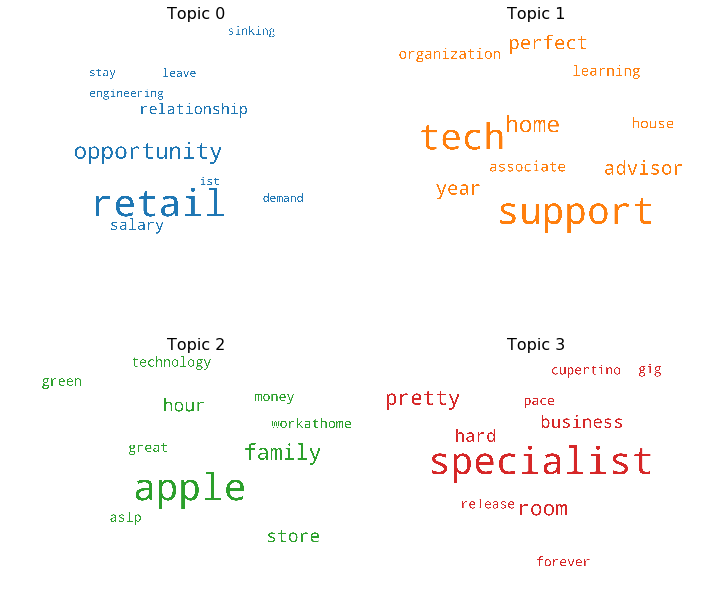

In [134]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Analysis

### Finding topics for each document

In [135]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Create DataFrame
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document
    for i, row in enumerate(ldamodel[corpus]):                   # call the optimal_model from LdaMallet (ldamodel=optimal_model)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)    # sort the dominant topic for each document (use row[0] for windows)
        
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:                                           # dominant topic
                wp = ldamodel.show_topic(topic_num)              # show the dominant topic column (topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])   # add keywords column to each dominant topic column
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                # add to dataframe columns: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)),
                # and keywords (topic_keywords)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'] # create dataframe title
    # Essentially, we sort the dominant topic for each document,
    # Then we add keywords column to each dominant topic column for each document, and append it to our sent_topics_df dataframe
    # (dataframe now include: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)), and keywords (topic_keywords))
    # Note that prop_topic is perc_contribution from output of keywords and their respective weights (ie. 'window', 0.0235866)
    # Finally name the dataframe columns for topic_num, prop_topic, topic_keywords to Dominant_topic, Perc_Contribution and Topic_Keywords
    
        
    # Add original text to the end of the output (recall that texts = data_lemmatized)
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    # we take out sent_topics_df dataframe that is configured, and add our texts to it

    
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
# texts=data since that is what we assigned in the format_topics_sentences function, but in the function we already
# called and added our data (texts=data_lemmatized) to the dataframe, which is why now we use texts=data default parameter


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()       # re-index
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']
# name all the columns for the DataFrame

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document
0,0,17.0,0.0541,"technical, time, analyst, bad, average, sqa, d...",GIS Data Analyst
1,1,5.0,0.0600,"company, love, reward, rewarding, success, enj...",Challenging Rewarding but ZERO worklife balanc...
2,2,23.0,0.0531,"good, fun, manager, worklife, retail, cooperat...",A Company as Meticulous as Their Products
3,3,22.0,0.0530,"support, tech, home, advisor, year, perfect, h...",AtHomeAdvisor
4,4,10.0,0.0486,"good, job, technical, review, flexible, poor, ...",Good
5,5,8.0,0.0486,"apple, family, hour, store, aslp, money, green...",Apple
6,6,12.0,0.0486,"work, genius, people, mac, environment, review...",Genius
7,7,15.0,0.0531,"place, challenge, dream, genius, device, stepp...",Great place to work and gain experience
8,8,16.0,0.0562,"senior, college, part, expert, gain, terrible,...",Senior managers
9,9,12.0,0.0605,"work, genius, people, mac, environment, review...",Mac Genius


### Finding documents for each topic

In [136]:
# Group top 26 documents for the 26 dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame() # Create a new DataFrame for our analysis

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') 
# Groupyby dominant topics in df_topic_sents_keywords from above (where we derived the DataFrame showing dominant topic for each document)

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
# Take sent_topics_sorteddf_mallet DataFrame and combine it with,
# the most (head(1)) dominant topic in sent_topcs_outdf_grpd (grp) sort by perc_contribution
# Essentially, we take our dataset with dominant topics and group it with texts that has the most contribution for each dominant topic

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Document"]

# Show the top 26 documents for the 26 dominant topic
sent_topics_sorteddf_mallet 

,Topic_Num,Topic_Perc_Contrib,Keywords,Document
0,0.0,0.0656,"work, make, associate, experience, start, tech...",Work on many impactful products
1,1.0,0.0733,"manager, team, student, desk, growth, app, lon...",Team Manager
2,2.0,0.1018,"business, store, medical, review, outstanding,...",Outstanding People Outstanding Place Outstandi...
3,3.0,0.0612,"great, head, worldclass, grass, politic, scien...",Great company with an awful medical insurer
4,4.0,0.0701,"company, benefit, excellent, management, alot,...",Excellent benefits Encourages growth Crazyfast...
5,5.0,0.0850,"company, love, reward, rewarding, success, enj...",If you love Microsoft in the s youll love Appl...
6,6.0,0.0740,"apple, great, environment, applecare, garbage,...",unless you work hours a day you have no chanc...
7,7.0,0.0754,"engineer, software, insurer, design, engineeri...",Software Engineer V
8,8.0,0.0871,"apple, family, hour, store, aslp, money, green...",Apple pros plus cons addition
9,9.0,0.0635,"specialist, dispatch, sycophant, lucky, remote...",Red Zone Specialist


### Document distribution across Topics

In [137]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of overall Documents for Each Topic (round to 4 decimals)
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Total Dominant Topic Number
topic_num_keywords = {'Topic_Num': pd.Series([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,
                                              11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,
                                              20.0,21.0,22.0,23.0,24.0,25.0])}
topic_num_keywords = pd.DataFrame(topic_num_keywords)
                      
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Reindex
df_dominant_topics.reset_index(drop=True, inplace=True)

# Change Column names
df_dominant_topics.columns = ['Dominant Topic', 'Num_Document', 'Perc_Document']

# Show
df_dominant_topics

,Dominant Topic,Num_Document,Perc_Document
0,0.0,30,0.060
1,1.0,15,0.030
2,2.0,15,0.030
3,3.0,19,0.038
4,4.0,21,0.042
5,5.0,21,0.042
6,6.0,15,0.030
7,7.0,20,0.040
8,8.0,18,0.036
9,9.0,29,0.058


## Answering the Questions

# Topics Analysis for Microsoft

In [138]:
# Filters to Microsoft only
dfm = df[df['company'] == 'microsoft']

In [139]:
# Filters the data to the column needed for topic modeling
dfm = dfm[['summary']]
dfm.shape

(17930, 1)

17,930 dataset with 1 type

In [140]:
dfm = dfm.head(500)

## Data Cleansing

In [141]:
data = dfm['summary'].values.tolist() # convert to list

import re
data = [re.sub(r'[^a-zA-Z ]+', '', str(sent)) for sent in data] # removes everything except letters and space, str(sent) converts to string

In [142]:
from pprint import pprint
pprint(data[:1])

['Microsoft']


## Pre-Processing

### Tokenization and Additional Cleansing

In [143]:
import gensim
from gensim.utils import simple_preprocess 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
        # deacc=True removes punctuations
        # simple_preprocess to tokenize, and clean up messy text (converts to lowercase and removes punctuations)
        
data_words = list(sent_to_words(data))

print(data_words[:1])   

[['microsoft']]


### Remove Stopwords

In [144]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) # add additional stop words

# Define functions for stopwords, bigram, trigram and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # clean out words using simple_preprocess (gensim) if the words are not already in stop_words (stop_words from NLTK)
    
# Remove Stop Words from simple_preprocess
data_words_nostops = remove_stopwords(data_words)

### Create and Apply Trigrams

In [145]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# min_count is minimum 5 letters
# threshold is 100 threshold in each word before accepting another word

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_trigram(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Trigrams from Gensim.models.phrases
data_words_trigrams = make_trigram(data_words_nostops)

### Lemmatize

In [146]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): # http://spacy.io/api/annotation
    texts_out = [] # creates a list
    for sent in texts:
        doc = nlp(" ".join(sent)) # adds English dictionary from Spacy to the texts by instantiating doc
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
# adds doc to texts_out list for all base token in doc, if these added doc are from a loose part of the speech in allowed_postags
# in other words, every (base) word that comes in will be added to the list, if these (loose) words are a NOUN, ADJ, VERB, or ADV
# lemma_ is base form of token and pos_ is lose parts of the speech
    return texts_out

# texts -> doc -> token
# texts -> sent -> doc -> token

# Initialize spacy 'en' model, keeping only tagger components (for efficieny)
# python -m spacy download en
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['microsoft']]


## Prepare Dictionary and Corpus

In [147]:
import gensim.corpora as corpora # dictionary

# Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [148]:
id2word[0]

'microsoft'

In [149]:
# Human readable format of corpus (term-frequency) for the first item
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('microsoft', 1)]]

## LDA Model

In [150]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics = 8, random_state = 100,
                                            update_every = 1, chunksize = 100, passes = 10, alpha = 'auto',
                                            per_word_topics=True)
# (corpus, dictionary, # of topics, random_state, how often the model parameters should be updated, # of document in each training chunk,
# total # of training passes, alpha is hyperparameter that affect sparsity of topics)
# Here we use 8 topics

# Print the keyword the 8 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.149*"work" + 0.149*"place" + 0.149*"great" + 0.067*"good" + '
  '0.039*"benefit" + 0.022*"career" + 0.021*"overall" + 0.015*"worklife" + '
  '0.013*"consultant" + 0.013*"working"'),
 (1,
  '0.096*"culture" + 0.062*"sale" + 0.055*"marketing" + 0.043*"excellent" + '
  '0.040*"team" + 0.035*"depend" + 0.029*"scientist" + 0.028*"solution" + '
  '0.026*"data" + 0.025*"professional"'),
 (2,
  '0.218*"company" + 0.158*"great" + 0.083*"good" + 0.049*"work" + 0.044*"job" '
  '+ 0.030*"love" + 0.017*"specialist" + 0.015*"bad" + 0.013*"not" + '
  '0.011*"support"'),
 (3,
  '0.074*"balance" + 0.070*"good" + 0.050*"work" + 0.048*"life" + '
  '0.047*"experience" + 0.045*"amazing" + 0.031*"customer" + 0.028*"pay" + '
  '0.027*"tech" + 0.023*"opportunity"'),
 (4,
  '0.215*"engineer" + 0.175*"software" + 0.055*"review" + 0.049*"advisor" + '
  '0.041*"product" + 0.034*"awesome" + 0.025*"solid" + 0.022*"title" + '
  '0.020*"employee" + 0.017*"first"'),
 (5,
  '0.145*"senior" + 0.044*"account" +

### LDA Model Performance

In [151]:
# Compute perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # A measure of how good the model is (lower the better)

# Compute coherence score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) # high the better


Perplexity:  -5.650555513326819

Coherence Score:  0.6443309094987812


### Visualize LDA Model

In [152]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # hides future warning

import pyLDAvis # interactive visualization for LDA
import pyLDAvis.gensim 

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.249407  0.000119       1        1  20.919456
0     -0.259189 -0.000852       2        1  19.645264
7      0.135915 -0.195151       3        1  12.073819
4      0.122441  0.256331       4        1  11.306057
1      0.112847  0.050566       5        1   9.506496
3     -0.076751 -0.009936       6        1   9.398113
6      0.100125 -0.000247       7        1   9.003726
5      0.114020 -0.100831       8        1   8.147068, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
6     Default  63.000000      company  63.000000  30.0000  30.0000
4     Default  44.000000      manager  44.000000  29.0000  29.0000
7     Default  86.000000        great  86.000000  28.0000  28.0000
26    Default  34.000000     engineer  34.000000  27.0000  27.0000
10    Default  41.000000        place  41.000000  26.0000  26.0000
114   Default  28.000000     software  28.000000  25.0000  25.0000
0     Default  24.000000    microsoft  24.000000  24.0000  24.0000
8     Default  61.000000         work  61.000000  23.0000  23.0000
122   Default  17.000000       senior  17.000000  22.0000  22.0000
17    Default  52.000000         good  52.000000  21.0000  21.0000
9     Default  17.000000      program  17.000000  20.0000  20.0000
11    Default  13.000000      culture  13.000000  19.0000  19.0000
19    Default  10.000000      balance  10.000000  18.0000  18.0000
94    Default   8.000000         sale   8.000000  17.0000  17.0000
12    Default   9.000000       review   9.000000  16.0000  16.0000
154   Default   7.000000    marketing   7.000000  15.0000  15.0000
105   Default  13.000000          job  13.000000  14.0000  14.0000
96    Default   8.000000      advisor   8.000000  13.0000  13.0000
119   Default   8.000000       intern   8.000000  12.0000  12.0000
23    Default   6.000000         life   6.000000  11.0000  11.0000
20    Default  11.000000      benefit  11.000000  10.0000  10.0000
97    Default   9.000000      product   9.000000   9.0000   9.0000
145   Default   6.000000   experience   6.000000   8.0000   8.0000
61    Default   6.000000      amazing   6.000000   7.0000   7.0000
25    Default   6.000000    excellent   6.000000   6.0000   6.0000
3     Default   5.000000      account   5.000000   5.0000   5.0000
85    Default   7.000000     director   7.000000   4.0000   4.0000
102   Default   5.000000         team   5.000000   3.0000   3.0000
134   Default   5.000000          sde   5.000000   2.0000   2.0000
5     Default   6.000000    technical   6.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
3      Topic8   4.958718      account   5.642976   2.3782  -3.1270
150    Topic8   4.015798      politic   4.700062   2.3502  -3.3379
41     Topic8   3.432357  engineering   4.116529   2.3257  -3.4949
334    Topic8   3.306911  environment   3.991748   2.3193  -3.5321
149    Topic8   2.957523          new   3.641832   2.2994  -3.6438
392    Topic8   2.438784          swe   3.122865   2.2603  -3.8366
390    Topic8   2.438784         msft   3.122865   2.2603  -3.8366
161    Topic8   2.212633    executive   2.896783   2.2381  -3.9339
151    Topic8   2.197589        satya   2.881834   2.2364  -3.9407
307    Topic8   2.131525        learn   2.816185   2.2290  -3.9713
200    Topic8   1.905333     terrible   2.590077   2.2005  -4.0835
197    Topic8   1.846703         much   2.530922   2.1923  -4.1147
387    Topic8   1.263235   researcher   1.947316   2.0747  -4.4944
379    Topic8   1.263235     farstill   1.947316   2.0747  -4.4944
388    Topic8   1.263235           ux   1.947316   2.0747  -4.4944
380    Topic8   1.263235        happy   1.947316   2.0747  -4.4944
399    Topic8   1.263219      license   1.947300   2.0747  -4.4944
176    Topic8   1.036824     position   1.721225   2.0006  -4.6919


## LDA Mallet Model

In [153]:
# Download file: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# Installing mallet: https://programminghistorian.org/en/lessons/topic-modeling-and-mallet#mac-instructions
# Download Java SE (download .zip instead of .exe for silent install)

import os
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'/Users/Mick/Desktop/mallet/'}) # create environment
mallet_path = '/Users/Mick/Desktop/mallet/bin/mallet' # update this path

In [154]:
ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=8,id2word=id2word)
# here we use 8 topics

In [155]:
# Show topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('company', 0.16463414634146342),
   ('job', 0.08536585365853659),
   ('product', 0.07926829268292683),
   ('advisor', 0.06097560975609756),
   ('director', 0.054878048780487805),
   ('excellent', 0.04878048780487805),
   ('awesome', 0.042682926829268296),
   ('sde', 0.036585365853658534),
   ('solution', 0.03048780487804878),
   ('opportunity', 0.03048780487804878)]),
 (1,
  [('great', 0.5586592178770949),
   ('sale', 0.061452513966480445),
   ('account', 0.03910614525139665),
   ('career', 0.027932960893854747),
   ('customer', 0.027932960893854747),
   ('analyst', 0.0223463687150838),
   ('employer', 0.01675977653631285),
   ('success', 0.0111731843575419),
   ('build', 0.0111731843575419),
   ('contract', 0.00558659217877095)]),
 (2,
  [('manager', 0.3142857142857143),
   ('program', 0.13142857142857142),
   ('senior', 0.12),
   ('balance', 0.03428571428571429),
   ('engineering', 0.02857142857142857),
   ('development', 0.022857142857142857),
   ('business', 0.022857142857

### LDA Mallet Model Performance

In [156]:
# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.7596174511851551


## Finding the Optimal Number of Topics for LDA Mallet Model

In [160]:
# compute coherence_values for LdaMallets models

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model) # adds different LdaMallet models based on num_topics(start, limit, step)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence()) # add the different LdaMallet models and compute Coherence score
    return model_list, coherence_values

# Recall previous LdaMallet model
# ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=10,id2word=id2word)
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")

# compute a list of LdaMallets models
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

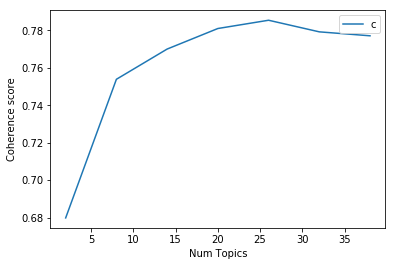

In [161]:
# show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [162]:
# Print the coherence scores
for m, cv in zip(x, coherence_values): # zip aggregate iterables (zero or more)
    print('Num Topics =', m, ' has Coherence Value of', round(cv, 4))
    # calls an iterated x (x = range(start, limit, step)) and coherence_values (4 decimals)

Num Topics = 2  has Coherence Value of 0.6798
Num Topics = 8  has Coherence Value of 0.7539
Num Topics = 14  has Coherence Value of 0.77
Num Topics = 20  has Coherence Value of 0.781
Num Topics = 26  has Coherence Value of 0.7854
Num Topics = 32  has Coherence Value of 0.7792
Num Topics = 38  has Coherence Value of 0.7771


In [163]:
# Select the model with highest coherence value and print the topics
optimal_model = model_list[4] # the 4th index from above output
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10)) # set num_words parament to show 10 words per topic

[(12,
  '0.479*"work" + 0.146*"technical" + 0.042*"employer" + 0.042*"azure" + '
  '0.042*"growth" + 0.021*"accountability" + 0.021*"vision" + 0.021*"janitor" '
  '+ 0.021*"con" + 0.021*"performance"'),
 (18,
  '0.500*"great" + 0.104*"ms" + 0.042*"learning" + 0.042*"lucky" + '
  '0.042*"solid" + 0.021*"advancement" + 0.021*"impact" + 0.021*"slow" + '
  '0.021*"success" + 0.021*"nice"'),
 (21,
  '0.561*"engineer" + 0.073*"field" + 0.049*"senior" + 0.049*"finance" + '
  '0.024*"decade" + 0.024*"pm" + 0.024*"expert" + 0.024*"nightmare" + '
  '0.024*"service" + 0.024*"hard"'),
 (0,
  '0.442*"work" + 0.115*"intern" + 0.115*"place" + 0.019*"control" + '
  '0.019*"regular" + 0.019*"moment" + 0.019*"define" + 0.019*"clarity" + '
  '0.019*"internship" + 0.019*"censorship"'),
 (6,
  '0.265*"culture" + 0.122*"benefit" + 0.082*"consultant" + 0.061*"group" + '
  '0.061*"good" + 0.041*"environment" + 0.041*"data" + 0.020*"rebound" + '
  '0.020*"notch" + 0.020*"top"'),
 (4,
  '0.491*"good" + 0.151*"w

### Visual the Optimal LDA Mallet Model

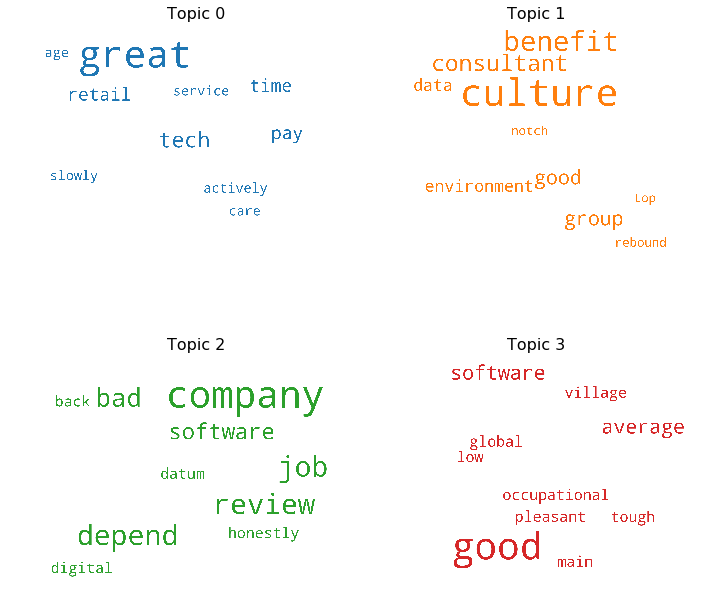

In [164]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Analysis

### Finding topics for each document

In [165]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Create DataFrame
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document
    for i, row in enumerate(ldamodel[corpus]):                   # call the optimal_model from LdaMallet (ldamodel=optimal_model)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)    # sort the dominant topic for each document (use row[0] for windows)
        
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:                                           # dominant topic
                wp = ldamodel.show_topic(topic_num)              # show the dominant topic column (topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])   # add keywords column to each dominant topic column
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                # add to dataframe columns: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)),
                # and keywords (topic_keywords)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'] # create dataframe title
    # Essentially, we sort the dominant topic for each document,
    # Then we add keywords column to each dominant topic column for each document, and append it to our sent_topics_df dataframe
    # (dataframe now include: dominant topic (topic_num), perc_contribution (prop_topic (4 decimal)), and keywords (topic_keywords))
    # Note that prop_topic is perc_contribution from output of keywords and their respective weights (ie. 'window', 0.0235866)
    # Finally name the dataframe columns for topic_num, prop_topic, topic_keywords to Dominant_topic, Perc_Contribution and Topic_Keywords
    
        
    # Add original text to the end of the output (recall that texts = data_lemmatized)
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    # we take out sent_topics_df dataframe that is configured, and add our texts to it

    
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
# texts=data since that is what we assigned in the format_topics_sentences function, but in the function we already
# called and added our data (texts=data_lemmatized) to the dataframe, which is why now we use texts=data default parameter


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()       # re-index
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']
# name all the columns for the DataFrame

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document
0,0,11.0,0.0508,"microsoft, intern, skill, long, explorer, comp...",Microsoft
1,1,15.0,0.0541,"place, amazing, year, senior, sde, customer, s...",Thoughts after years
2,2,12.0,0.0552,"work, technical, employer, azure, growth, acco...",Technical Account Manager
3,3,18.0,0.0455,"great, ms, learning, lucky, solid, advancement...",Great company
4,4,23.0,0.0489,"company, job, employee, project, excite, thing...",Great Company to work for
5,5,17.0,0.0541,"manager, program, solution, principal, slow, m...",Sr Program Manager
6,6,0.0,0.0468,"work, intern, place, control, regular, moment,...",Great place to work
7,7,23.0,0.0477,"company, job, employee, project, excite, thing...",Great company
8,8,0.0,0.0447,"work, intern, place, control, regular, moment,...",Great company to work for
9,9,11.0,0.0541,"microsoft, intern, skill, long, explorer, comp...",Microsoft Work Culture Review


### Finding documents for each topic

In [166]:
# Group top 26 documents for the 26 dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame() # Create a new DataFrame for our analysis

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') 
# Groupyby dominant topics in df_topic_sents_keywords from above (where we derived the DataFrame showing dominant topic for each document)

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
# Take sent_topics_sorteddf_mallet DataFrame and combine it with,
# the most (head(1)) dominant topic in sent_topcs_outdf_grpd (grp) sort by perc_contribution
# Essentially, we take our dataset with dominant topics and group it with texts that has the most contribution for each dominant topic

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Document"]

# Show the top 26 documents for the 26 dominant topic
sent_topics_sorteddf_mallet 

,Topic_Num,Topic_Perc_Contrib,Keywords,Document
0,0.0,0.0719,"work, intern, place, control, regular, moment,...",Chaos with moments of clarity
1,1.0,0.0603,"good, software, average, low, main, occupation...",Good benefits not the best culture
2,2.0,0.0690,"place, program, awesome, business, analyst, po...",Sr Business Analyst
3,3.0,0.0573,"work, manager, swe, coach, success, track, med...",SWE
4,4.0,0.0541,"good, work, engineer, data, farstill, premier,...",Sr Data Scientist
5,5.0,0.0706,"sale, great, team, sde, professional, store, g...",Technical Solutions Professional Sales Dont d...
6,6.0,0.0774,"culture, benefit, consultant, group, good, env...",Top notch benefits and work like balance
7,7.0,0.0726,"balance, microsoft, life, culture, worklife, c...",Good work life balance
8,8.0,0.0810,"great, career, specialist, microsoft, satya, s...",Average culture great benefits great career st...
9,9.0,0.0747,"company, job, depend, review, bad, software, d...",The best thing I can say is it is not the wors...


### Document distribution across Topics

In [167]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of overall Documents for Each Topic (round to 4 decimals)
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Total Dominant Topic Number
topic_num_keywords = {'Topic_Num': pd.Series([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,
                                              11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,
                                              20.0,21.0,22.0,23.0,24.0,25.0])}
topic_num_keywords = pd.DataFrame(topic_num_keywords)
                      
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Reindex
df_dominant_topics.reset_index(drop=True, inplace=True)

# Change Column names
df_dominant_topics.columns = ['Dominant Topic', 'Num_Document', 'Perc_Document']

# Show
df_dominant_topics

,Dominant Topic,Num_Document,Perc_Document
0,0.0,29,0.058
1,1.0,20,0.040
2,2.0,24,0.048
3,3.0,12,0.024
4,4.0,12,0.024
5,5.0,20,0.040
6,6.0,19,0.038
7,7.0,17,0.034
8,8.0,23,0.046
9,9.0,15,0.030


## Answering the Questions

# Answering the Final Questions